#Introduction
For this machine learning capstone, I used a Kaggle dataset from the following URL: https://www.kaggle.com/jpacse/datasets-for-churn-telecom#cell2celltrain.csv.  This has also been downloaded to my Github repository at 'https://raw.githubusercontent.com/lvang77/ML/master/cell2celltrain.csv'.  The dataset looks to be a cellphone carrier's dataset that includes a target variable labeled Churn.  I used this dataset in an attempt to predict and model if a customer would churn or not.

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import timeit
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report, confusion_matrix, make_scorer, roc_auc_score, roc_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from xgboost import XGBClassifier
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectFromModel


%matplotlib inline
sns.set()


In [0]:
#Function to visualize confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
#Function to plot ROC_AUC curve and print and return score for No Churn
def plot_roc_auc(clf, X_test, y_test):
  probs = clf.predict_proba(X_test)
  probs = probs[:, 1]

  fpr, tpr, _ = roc_curve(y_test, probs)

  plt.plot(fpr, tpr, marker='.')
  plt.plot([0, 1], ls='--')
  plt.show()
  print('ROC AUC:', roc_auc_score(y_test, probs))
  return(roc_auc_score(y_test, probs))


In [0]:
#Variable to define how many CPU threads to use for different classifiers and GridSearchCV that support defining n_jobs
num_jobs = 8

In [343]:
#Read in CSV data from Github
train_df = pd.read_csv('https://raw.githubusercontent.com/lvang77/ML/master/cell2celltrain.csv')
train_df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


#EDA Explore Data Types

In [344]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

#EDA Check for other Categorical features

In [345]:
features_df = train_df.copy()

numeric_columns = features_df.select_dtypes(['float64', 'int64']).columns

for col in numeric_columns:
  if features_df[col].nunique() < 25:
    print(col, features_df[col].unique())

UniqueSubs [  2   1   3   5   6   4   7  12  11   9   8  10  13  18 196]
ActiveSubs [ 1  2  3  4  0  5  8  6  9 53 11  7]
Handsets [ 2.  1.  9.  4.  3. 10.  5.  8. 18.  7.  6. 24. 12. 11. 14. 13. 17. 16.
 21. 19. 15. 22. 20. nan]
HandsetModels [ 2.  1.  4.  3.  5.  6.  9.  7. 10.  8. 11. 15. 14. nan]
RetentionCalls [1 0 3 2 4]
RetentionOffersAccepted [0 1 2 3]
ReferralsMadeBySubscriber [ 0  1  2  3  4  7  5  6 16 11  8  9 35]
IncomeGroup [4 5 6 9 1 7 3 0 8 2]
AdjustmentsToCreditRating [ 0  1  3  2  5  4  9  6 10  8  7 11 25 21 12]


#EDA Check object datatypes
Check to see if any object dataytpe columns are actually numeric instead.

In [346]:
obj_columns = features_df.select_dtypes('object').columns

for col in obj_columns:
  if features_df[col].nunique() < 25:
    #print(col, features_df[col].unique())
    print(features_df[col].value_counts(),'\n')
  else:
    print(col, 'has',features_df[col].nunique(), 'values\n')

No     36336
Yes    14711
Name: Churn, dtype: int64 

ServiceArea has 747 values

No     38679
Yes    12368
Name: ChildrenInHH, dtype: int64 

No     43956
Yes     7091
Name: HandsetRefurbished, dtype: int64 

Yes    46046
No      5001
Name: HandsetWebCapable, dtype: int64 

No     41524
Yes     9523
Name: TruckOwner, dtype: int64 

No     46894
Yes     4153
Name: RVOwner, dtype: int64 

Known      33987
Unknown    17060
Name: Homeownership, dtype: int64 

No     32596
Yes    18451
Name: BuysViaMailOrder, dtype: int64 

No     31821
Yes    19226
Name: RespondsToMailOffers, dtype: int64 

No     50295
Yes      752
Name: OptOutMailings, dtype: int64 

No     48168
Yes     2879
Name: NonUSTravel, dtype: int64 

No     41583
Yes     9464
Name: OwnsComputer, dtype: int64 

Yes    34503
No     16544
Name: HasCreditCard, dtype: int64 

No     41223
Yes     9824
Name: NewCellphoneUser, dtype: int64 

No     44012
Yes     7035
Name: NotNewCellphoneUser, dtype: int64 

No     50368
Yes      679


#EDA Check object datatypes
Removing HandsetPrice feature due to too many unknown values and ServiceArea which has 747 object values

In [0]:
features_df.drop(['HandsetPrice', 'ServiceArea'], axis=1, inplace=True)

#EDA Missing Values
Due to the fact that the features were not fully documented in the dataset, I chose to drop all NA values. There's a concern for example with HandsetModels where it could represent how many handmodels the customer has, or its an anonymouse numerical value for various handset models as to not disclose the actual handset model.  We still have 49,752 rows of data and only lost about 1200 rows.

In [348]:
features_df.dropna(inplace=True)
features_df.drop('CustomerID', axis=1, inplace=True)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49776 entries, 0 to 51043
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      49776 non-null  object 
 1   MonthlyRevenue             49776 non-null  float64
 2   MonthlyMinutes             49776 non-null  float64
 3   TotalRecurringCharge       49776 non-null  float64
 4   DirectorAssistedCalls      49776 non-null  float64
 5   OverageMinutes             49776 non-null  float64
 6   RoamingCalls               49776 non-null  float64
 7   PercChangeMinutes          49776 non-null  float64
 8   PercChangeRevenues         49776 non-null  float64
 9   DroppedCalls               49776 non-null  float64
 10  BlockedCalls               49776 non-null  float64
 11  UnansweredCalls            49776 non-null  float64
 12  CustomerCareCalls          49776 non-null  float64
 13  ThreewayCalls              49776 non-null  flo

#EDA Outliers

Use boxplots to look for outliers. This is for reference and I'll be using models that don't do anything with outlier data, and then model again using winsorizing to deal with outliers to see if there is any improvements in the models.

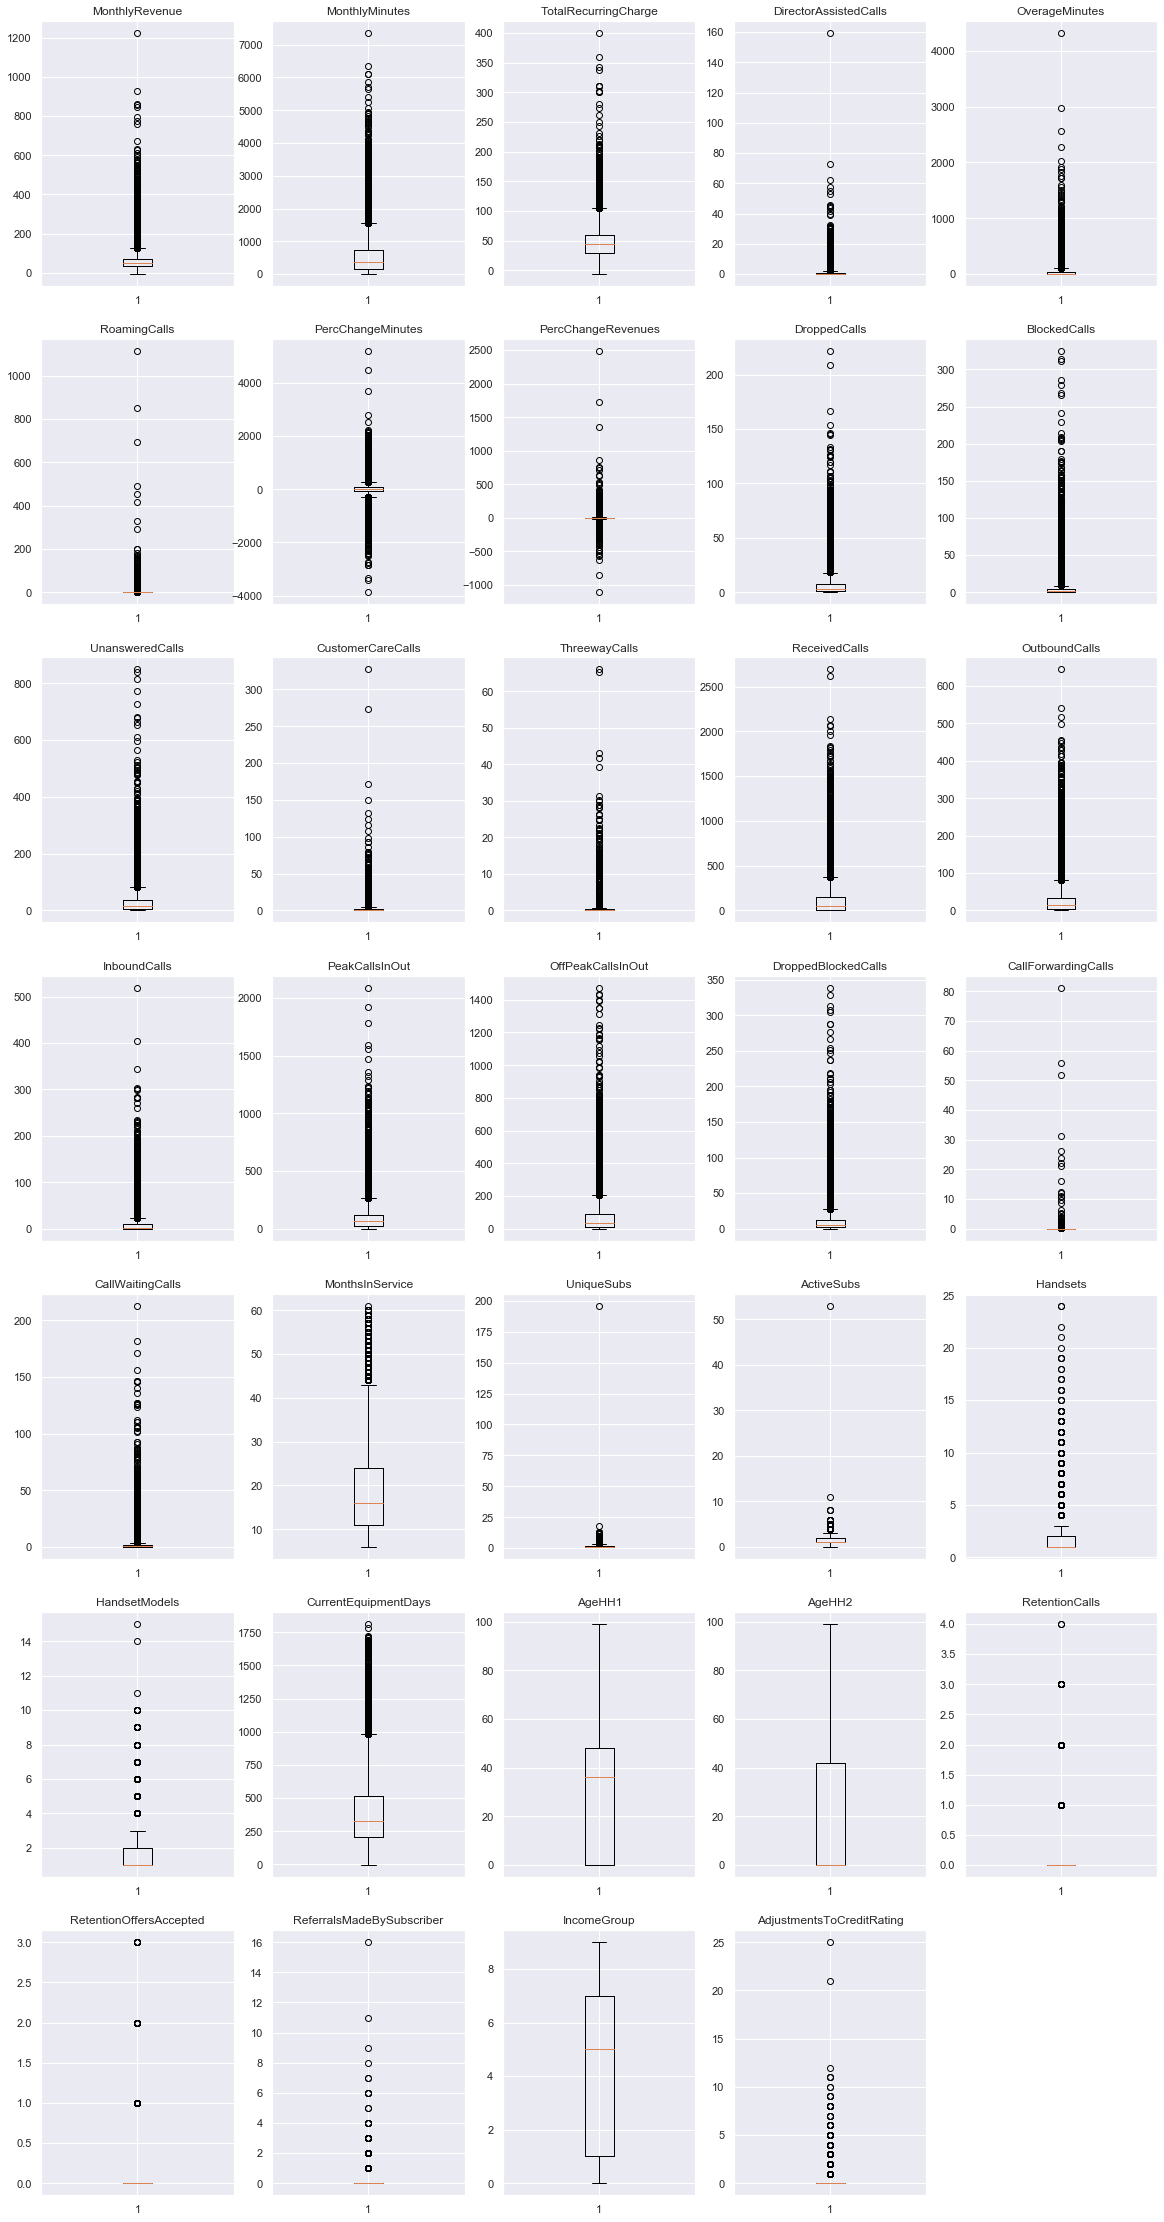

In [349]:
numeric_columns = features_df.select_dtypes(['float64', 'int64']).columns
plt.figure(figsize=(20,40))
for i, col in enumerate(numeric_columns):
  plt.subplot(math.ceil(len(numeric_columns)/5), 5, i+1)
  plt.boxplot(features_df[col])
  plt.title(col)

plt.show()


#EDA Histogram

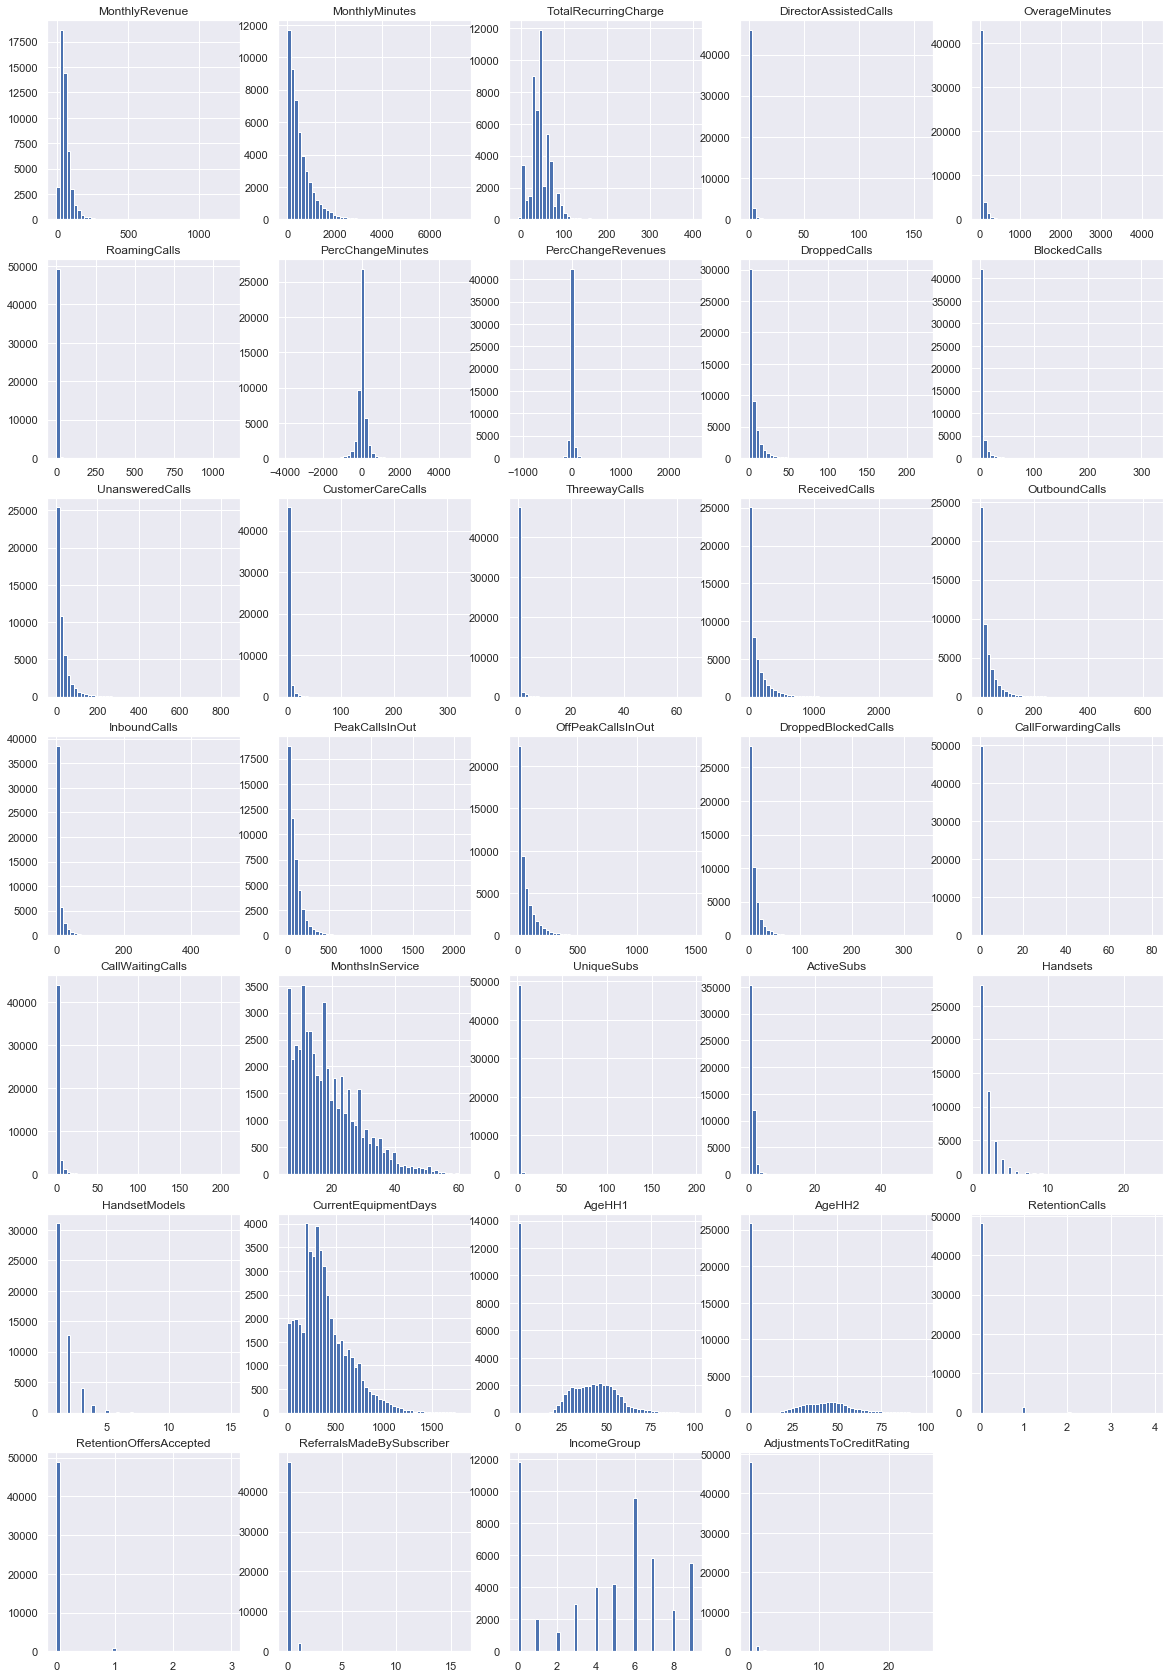

In [350]:
#Plot histogram of all numeric features
plt.figure(figsize=(20,30))
for i, col in enumerate(numeric_columns):
  plt.subplot(math.ceil(len(numeric_columns)/5), 5, i+1)
  plt.hist(features_df[col], bins=50)
  plt.title(col)

plt.show()

#Feature Engineering

CreditRating feature is a categorical datatype but each categorical value is ordinal related in value so we need to convert each categorical value to a numerical value using OrdinalEncoder.

In [351]:
#Find categorical values of CreditRating feature
features_df['CreditRating'].unique()

array(['1-Highest', '4-Medium', '3-Good', '2-High', '5-Low', '6-VeryLow',
       '7-Lowest'], dtype=object)

In [352]:
#Use OrdinalEncoder to covert categorical values to ordinal related numeric values, 0-6 with 6 being highest credit rating
cred_rating = np.array(features_df['CreditRating']).reshape(-1,1)
encoder = OrdinalEncoder(categories=[['7-Lowest', '6-VeryLow', '5-Low', '4-Medium', '3-Good', '2-High', '1-Highest']], dtype='int64')
encoder.fit_transform(cred_rating)

array([[6],
       [3],
       [4],
       ...,
       [6],
       [2],
       [4]], dtype=int64)

In [0]:
#Create new feature Cred_Rating with our OrdinalEncoder array and drop old categorical feature CreditRating
data_df = features_df.copy()
data_df['Cred_Rating'] = encoder.fit_transform(cred_rating)
data_df.drop('CreditRating', axis=1, inplace=True)

In [354]:
#Convert remaining categorical features using hot encoding
obj_columns = data_df.select_dtypes('object').columns

for col in obj_columns:
  if col != 'Churn':
    data_df = pd.concat([data_df, pd.get_dummies(data_df[col], prefix=col, drop_first=False)], axis=1)
    data_df.drop(col, axis=1, inplace=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49776 entries, 0 to 51043
Data columns (total 83 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        49776 non-null  object 
 1   MonthlyRevenue               49776 non-null  float64
 2   MonthlyMinutes               49776 non-null  float64
 3   TotalRecurringCharge         49776 non-null  float64
 4   DirectorAssistedCalls        49776 non-null  float64
 5   OverageMinutes               49776 non-null  float64
 6   RoamingCalls                 49776 non-null  float64
 7   PercChangeMinutes            49776 non-null  float64
 8   PercChangeRevenues           49776 non-null  float64
 9   DroppedCalls                 49776 non-null  float64
 10  BlockedCalls                 49776 non-null  float64
 11  UnansweredCalls              49776 non-null  float64
 12  CustomerCareCalls            49776 non-null  float64
 13  ThreewayCalls   

Target feature is Churn so check to see how our target feature is distributed between the two values

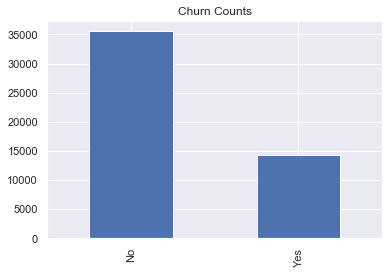

In [355]:
#Barplot of target feature Churn
data_df.Churn.value_counts().plot(kind='bar')
plt.title('Churn Counts')
plt.show()

Target feature is a categorical feature so converting to binary so that we can compute ROC_AUC correctly later

In [356]:
#Value counts of target feature values
data_df.loc[(data_df.Churn == 'Yes'), 'Churn'] = 1
data_df.loc[(data_df.Churn == 'No'), 'Churn'] = 0
data_df.Churn.value_counts()

0    35519
1    14257
Name: Churn, dtype: int64

We need to split up our data set into a test and train set to test our models.  For the training set, once it is split up, we need to merge back the feature data set back with the target so that we can deal with the class imbalance. As expected, there is alot more datapoints that are not churn customers compared to churn customers. This class imbalance will affect our model performance greatly so I'm going to modify the training dataset using undersampling, oversampling, and SMOTE and then using each method in the different models to see which performs better.

In [357]:
X = data_df.drop('Churn', axis=1)
y = data_df['Churn'].astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

merge_df = pd.concat([X_train, y_train], axis=1)

churn = merge_df[merge_df['Churn'] == 1]
not_churn = merge_df[merge_df['Churn'] == 0]

print('Training set Churn:',churn.shape[0])
print('Training set Not Churn:',not_churn.shape[0])

Training set Churn: 10731
Training set Not Churn: 26601


In [358]:
#Create undersampled training dataset
not_churn_under = resample(not_churn, replace=False, n_samples = len(churn), random_state=150)
undersampled = pd.concat([not_churn_under, churn])

X_train_under = undersampled.drop('Churn', axis=1)
y_train_under = undersampled['Churn']

undersampled.Churn.value_counts()

1    10731
0    10731
Name: Churn, dtype: int64

In [359]:
#Create oversampled training dataset
churn_over = resample(churn, replace=True, n_samples=len(not_churn), random_state=125)

oversampled = pd.concat([not_churn, churn_over])

X_train_over = oversampled.drop('Churn', axis=1)
y_train_over = oversampled['Churn']

oversampled['Churn'].value_counts()

1    26601
0    26601
Name: Churn, dtype: int64

In [360]:
#Create SMOTE training dataset
sm = SMOTE(random_state=50, n_jobs=-1)

X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Creating custom scorers for testing with GridSearchCV module from SKlearn

In [0]:
recall_scorer = make_scorer(recall_score, pos_label=1)
precision_scorer = make_scorer(precision_score, pos_label=1)
f1_scorer = make_scorer(f1_score, pos_label=1, average='binary')

#Array to store ROC_AUC scores for each model

In [362]:
model_scores = pd.DataFrame(columns={'Model', 'Score'})
model_scores.head()

,Model,Score


#Model testing
Here I'm going to test logistic regression, gradient boosting, KNN classification, decision trees, and random forests to see which one performs the best according to ROC_AUC score of Churn test dataset. I'll be using SKlearn's GridSearchCV for both crossfold validation and hyperparameter tuning of the various classification models to see which hyperparameter settings maximize ROC_AUC scores. I'll save the scores into a dataframe so that I can sort it afterwards to easy reference to see which model and hyperparameters performed the best.

#Logistic Regression Undersampling

In [363]:
#Testing to see which combinations of penalty, max_iter, and C score the highest on average
hyper_para = [{'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': range(100, 2000, 100), 'C': [1.0], 'random_state': [50]}, 
              {'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': range(100, 2000, 100), 'C': [1.0], 'random_state': [50]}]

lr_under = GridSearchCV(LogisticRegression(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
lr_under.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done 190 out of 190 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid=[{'C': [1.0], 'max_iter': range(100, 2000, 100),
                          'penalty': ['l2'], 'random_state': [50],
                          'solver': ['liblinear']},
                         {'C': [1.0], 'max_iter': range(100, 2000, 100),
                          'penalty': ['l1'], 'random_state': [50],
                       

In [364]:
#Best score and hyperparameters
lr_under.best_score_, lr_under.best_params_

(0.6093749154990732,
 {'C': 1.0,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

In [365]:
#Create new model using best hyperparameters and run model against test dataset to see model performance
lr_under2 = LogisticRegression(**lr_under.best_params_)
lr_under2.fit(X_train_under, y_train_under)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=50, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

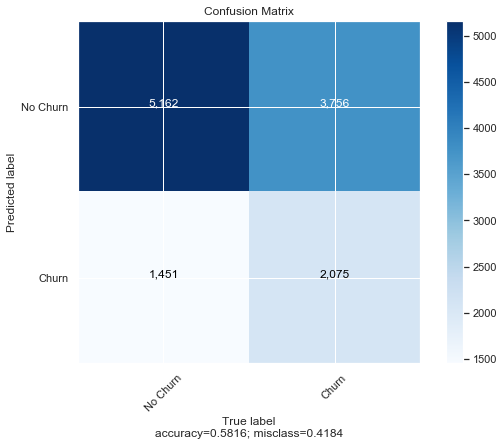

              precision    recall  f1-score   support

    No Churn       0.78      0.58      0.66      8918
       Churn       0.36      0.59      0.44      3526

    accuracy                           0.58     12444
   macro avg       0.57      0.58      0.55     12444
weighted avg       0.66      0.58      0.60     12444



In [366]:
#Check confusion matrix and classification report to see model performance
preds = lr_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

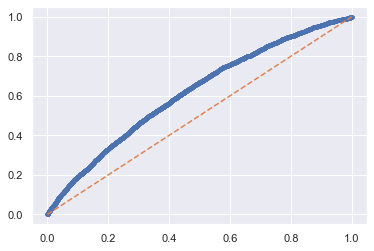

ROC AUC: 0.6174871206328486


In [367]:
#Plot ROC_AUC curve and score of model and save model name and ROC_AUC score to model_scores dataframe
model_scores = model_scores.append({'Model': 'lr_under2', 'Score': plot_roc_auc(lr_under2, X_test, y_test)}, ignore_index=True)

In [368]:
#Add C values to search grid
hyper_para = [{'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}, 
              {'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}]

lr_under3 = GridSearchCV(LogisticRegression(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
lr_under3.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:  5.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penalty': ['l2'],
                          'random_state': [50], 'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penalty': ['l1'],

In [369]:
lr_under3.best_score_, lr_under3.best_params_

(0.6107082979440892,
 {'C': 0.1,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

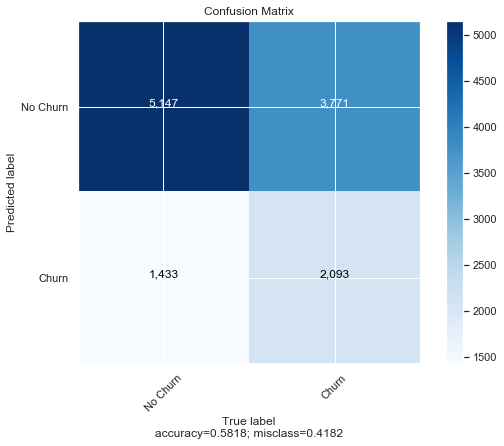

              precision    recall  f1-score   support

    No Churn       0.78      0.58      0.66      8918
       Churn       0.36      0.59      0.45      3526

    accuracy                           0.58     12444
   macro avg       0.57      0.59      0.56     12444
weighted avg       0.66      0.58      0.60     12444



In [370]:
lr_under4 = LogisticRegression(**lr_under3.best_params_)
lr_under4.fit(X_train_under, y_train_under)
preds = lr_under4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

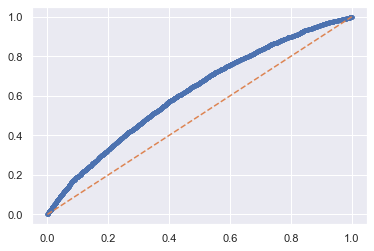

ROC AUC: 0.6169464918726961


In [371]:
model_scores = model_scores.append({'Model': 'lr_under4', 'Score': plot_roc_auc(lr_under4, X_test, y_test)}, ignore_index=True)

#Logistic Regression Oversampling

In [372]:
hyper_para = [{'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': range(100, 1000, 100), 'C': [0.001, 0.01, 0.1, 1], 'random_state': [50]}, 
              {'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': range(100, 1000, 100), 'C': [0.001, 0.01, 0.1, 1], 'random_state': [50]}]

lr_over = GridSearchCV(LogisticRegression(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
lr_over.fit(X_train_over, y_train_over)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   17.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 14.6min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 23.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1],
                          'max_iter': range(100, 1000, 100), 'penalty': ['l2'],
                          'random_state': [50], 'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1],
                          'max_iter': range(100, 1000, 100), 'penalty': ['l1'],
             

In [373]:
lr_over.best_score_, lr_over.best_params_

(0.6159556431477566,
 {'C': 0.1,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

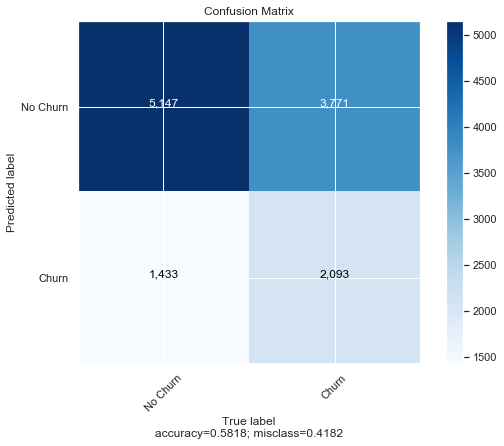

              precision    recall  f1-score   support

    No Churn       0.78      0.58      0.66      8918
       Churn       0.36      0.59      0.45      3526

    accuracy                           0.58     12444
   macro avg       0.57      0.59      0.56     12444
weighted avg       0.66      0.58      0.60     12444



In [374]:
lr_over2 = LogisticRegression(**lr_over.best_params_)
lr_over2.fit(X_train_under, y_train_under)
preds = lr_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

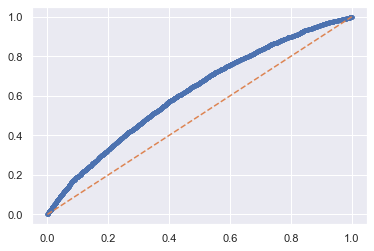

ROC AUC: 0.6169464918726961


In [375]:
model_scores = model_scores.append({'Model': 'lr_over2', 'Score': plot_roc_auc(lr_over2, X_test, y_test)}, ignore_index=True)

#Logistic Regression SMOTE Oversampling

In [376]:
hyper_para = [{'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': range(50, 110, 10), 'C': [0.1, 1, 10], 'random_state': [50]}, 
              {'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': range(50, 110, 10), 'C': [0.1, 1, 10], 'random_state': [50]}]

lr_smote = GridSearchCV(LogisticRegression(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
lr_smote.fit(X_train_smote, y_train_smote)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   41.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 14.5min
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed: 17.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid=[{'C': [0.1, 1, 10], 'max_iter': range(50, 110, 10),
                          'penalty': ['l2'], 'random_state': [50],
                          'solver': ['liblinear']},
                         {'C': [0.1, 1, 10], 'max_iter': range(50, 110, 10),
                          'penalty': ['l1'], 'random_state': [50],
               

In [377]:
lr_smote.best_score_, lr_smote.best_params_

(0.6169099224203766,
 {'C': 10,
  'max_iter': 50,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

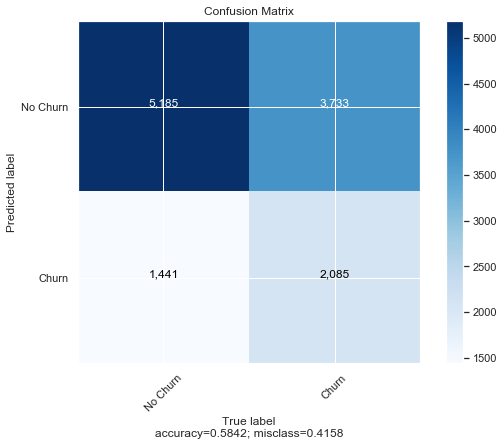

              precision    recall  f1-score   support

    No Churn       0.78      0.58      0.67      8918
       Churn       0.36      0.59      0.45      3526

    accuracy                           0.58     12444
   macro avg       0.57      0.59      0.56     12444
weighted avg       0.66      0.58      0.60     12444



In [378]:
lr_smote2 = LogisticRegression(**lr_smote.best_params_)
lr_smote2.fit(X_train_smote, y_train_smote)
preds = lr_smote2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

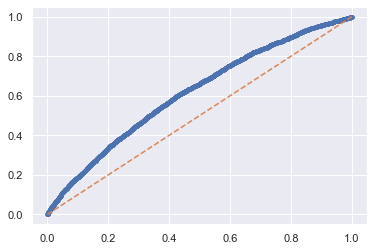

ROC AUC: 0.617040084251586


In [379]:
model_scores = model_scores.append({'Model': 'lr_smote2', 'Score': plot_roc_auc(lr_smote2, X_test, y_test)}, ignore_index=True)

#Gradient Boost Undersampling

In [380]:
hyper_para = {'n_estimators': range(90, 200, 10), 'max_depth': range(4, 8, 1), 'random_state': [50], 'loss': ['deviance'], 'max_features': [15, 25, 2], 'subsample': [0.8], 'learning_rate': [0.1]}

gradboost_under = GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
gradboost_under.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   56.8s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  8.7min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 660 out of 660 | elapsed: 14.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [381]:
gradboost_under.best_score_, gradboost_under.best_params_

(0.6686996936821595,
 {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 4,
  'max_features': 25,
  'n_estimators': 170,
  'random_state': 50,
  'subsample': 0.8})

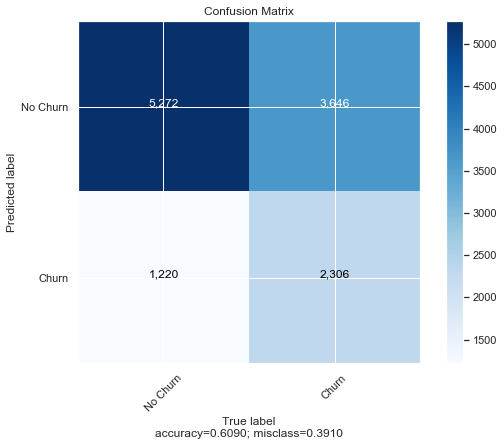

              precision    recall  f1-score   support

    No Churn       0.81      0.59      0.68      8918
       Churn       0.39      0.65      0.49      3526

    accuracy                           0.61     12444
   macro avg       0.60      0.62      0.59     12444
weighted avg       0.69      0.61      0.63     12444



In [382]:
gradboost_under2 = ensemble.GradientBoostingClassifier(**gradboost_under.best_params_)
gradboost_under2.fit(X_train_under, y_train_under)
preds = gradboost_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

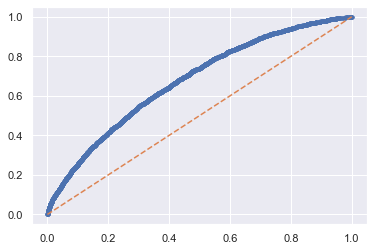

ROC AUC: 0.6767090896994702


In [383]:
model_scores = model_scores.append({'Model': 'gradboost_under2', 'Score': plot_roc_auc(gradboost_under2, X_test, y_test)}, ignore_index=True)

In [384]:
hyper_para = {'n_estimators': range(150, 200, 10), 'max_depth': range(2, 6, 1), 'random_state': [50], 'loss': ['deviance'], 'max_features': [25, 35, 5], 'subsample': np.arange(0.6, 1, 0.1), 'learning_rate': np.arange(0.05, 0.2, 0.5)}

gradboost_under3 = GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
gradboost_under3.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   48.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 10.3min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed: 16.9min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed: 25.8min
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed: 26.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [385]:
gradboost_under3.best_score_, gradboost_under3.best_params_

(0.6713628065483561,
 {'learning_rate': 0.05,
  'loss': 'deviance',
  'max_depth': 5,
  'max_features': 35,
  'n_estimators': 190,
  'random_state': 50,
  'subsample': 0.7})

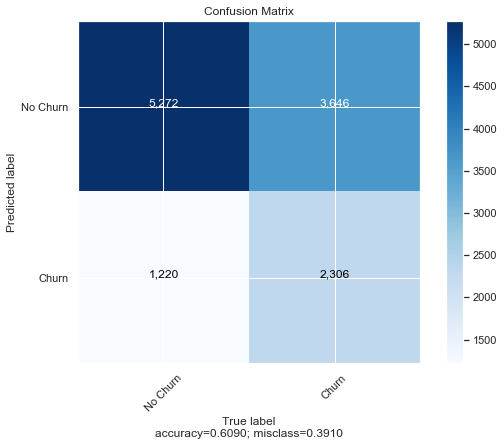

              precision    recall  f1-score   support

    No Churn       0.81      0.59      0.68      8918
       Churn       0.39      0.65      0.49      3526

    accuracy                           0.61     12444
   macro avg       0.60      0.62      0.59     12444
weighted avg       0.69      0.61      0.63     12444



In [386]:
gradboost_under4 = ensemble.GradientBoostingClassifier(**gradboost_under3.best_params_)
gradboost_under4.fit(X_train_under, y_train_under)
preds = gradboost_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

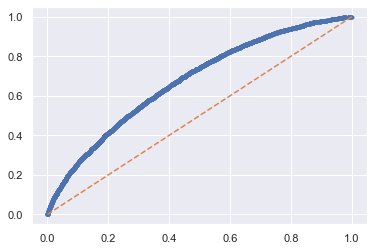

ROC AUC: 0.6759542129418384


In [387]:
model_scores = model_scores.append({'Model': 'gradboost_under4', 'Score': plot_roc_auc(gradboost_under4, X_test, y_test)}, ignore_index=True)

#Gradient Boosting Oversampling

In [388]:
hyper_para = {'n_estimators': range(150, 200, 10), 'max_depth': range(2, 6, 1), 'random_state': [50], 'loss': ['deviance'], 'max_features': [25, 35, 5], 'subsample': [0.8], 'learning_rate': [0.1]}

gradboost_over = GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
gradboost_over.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   18.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  7.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 17.7min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed: 18.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [389]:
gradboost_over.best_score_, gradboost_over.best_params_

(0.7647956843614668,
 {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 5,
  'max_features': 35,
  'n_estimators': 190,
  'random_state': 50,
  'subsample': 0.8})

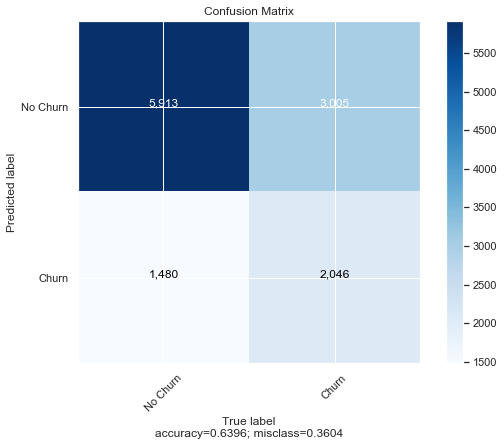

              precision    recall  f1-score   support

    No Churn       0.80      0.66      0.73      8918
       Churn       0.41      0.58      0.48      3526

    accuracy                           0.64     12444
   macro avg       0.60      0.62      0.60     12444
weighted avg       0.69      0.64      0.65     12444



In [390]:
gradboost_over2 = ensemble.GradientBoostingClassifier(**gradboost_over.best_params_)
gradboost_over2.fit(X_train_over, y_train_over)
preds = gradboost_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

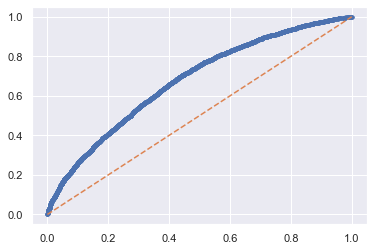

ROC AUC: 0.6772255809755665


In [391]:
model_scores = model_scores.append({'Model': 'gradboost_over2', 'Score': plot_roc_auc(gradboost_over2, X_test, y_test)}, ignore_index=True)

In [392]:
hyper_para = {'n_estimators': [190], 'max_depth': [5], 'random_state': [50], 'loss': ['deviance'], 'max_features': [35], 'subsample': [0.6, 0.7, 0.8, 0.9], 'learning_rate': np.arange(0.05, 0.2, 0.05)}

gradboost_over3 = GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
gradboost_over3.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   55.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  8.0min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 11.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [393]:
gradboost_over3.best_score_, gradboost_over3.best_params_

(0.7998090273912792,
 {'learning_rate': 0.2,
  'loss': 'deviance',
  'max_depth': 5,
  'max_features': 35,
  'n_estimators': 190,
  'random_state': 50,
  'subsample': 0.9})

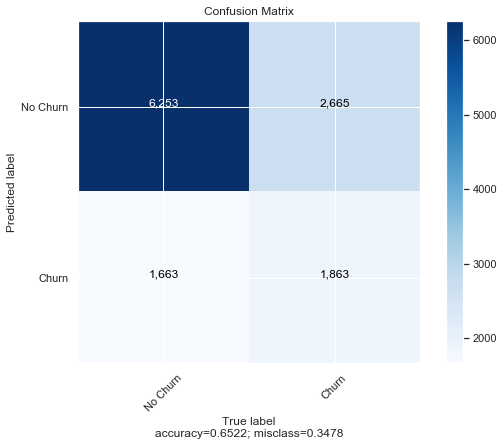

              precision    recall  f1-score   support

    No Churn       0.79      0.70      0.74      8918
       Churn       0.41      0.53      0.46      3526

    accuracy                           0.65     12444
   macro avg       0.60      0.61      0.60     12444
weighted avg       0.68      0.65      0.66     12444



In [394]:
gradboost_over4 = ensemble.GradientBoostingClassifier(**gradboost_over3.best_params_)
gradboost_over4.fit(X_train_over, y_train_over)
preds = gradboost_over4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

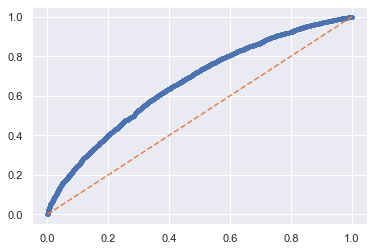

ROC AUC: 0.664635323004059


In [395]:
model_scores = model_scores.append({'Model': 'gradboost_over4', 'Score': plot_roc_auc(gradboost_over4, X_test, y_test)}, ignore_index=True)

#Gradient Boost SMOTE Oversampling

In [396]:
hyper_para = {'n_estimators': range(150, 200, 10), 'max_depth': range(2, 6, 1), 'random_state': [50], 'loss': ['deviance'], 'max_features': [25, 35, 5], 'subsample': [0.8], 'learning_rate': [0.1]}

gradboost_smote = GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
gradboost_smote.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   35.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 14.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 38.0min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed: 39.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [397]:
gradboost_smote.best_score_, gradboost_smote.best_params_

(0.8651911895106826,
 {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 5,
  'max_features': 35,
  'n_estimators': 180,
  'random_state': 50,
  'subsample': 0.8})

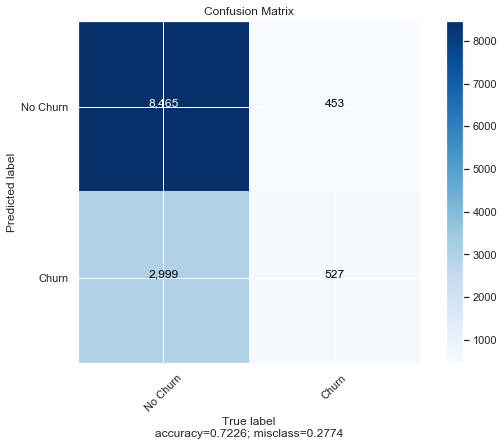

              precision    recall  f1-score   support

    No Churn       0.74      0.95      0.83      8918
       Churn       0.54      0.15      0.23      3526

    accuracy                           0.72     12444
   macro avg       0.64      0.55      0.53     12444
weighted avg       0.68      0.72      0.66     12444



In [398]:
gradboost_smote2 = ensemble.GradientBoostingClassifier(**gradboost_smote.best_params_)
gradboost_smote2.fit(X_train_smote, y_train_smote)
preds = gradboost_smote2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

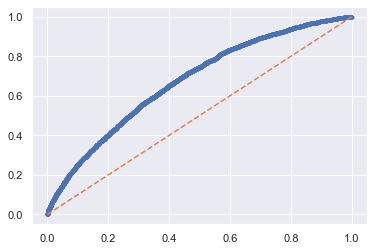

ROC AUC: 0.6758425890037127


In [399]:
model_scores = model_scores.append({'Model': 'gradboost_smote2', 'Score': plot_roc_auc(gradboost_smote2, X_test, y_test)}, ignore_index=True)

#KNN Classification Undersampling

In [400]:
hyper_para = {'leaf_size': range(10, 30, 5), 'n_neighbors': range(10, 20, 1), 'p': [1, 2], 'n_jobs': [num_jobs // 2]}

knn_under = GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
knn_under.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   18.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 10.2min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 18.8min
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed: 27.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'leaf_size': range(10, 30, 5), 'n_jobs': [4],
                         'n_neighbors': range(10, 20), 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', verbose=5)

In [401]:
knn_under.best_score_, knn_under.best_params_

(0.5932413056978394, {'leaf_size': 20, 'n_jobs': 4, 'n_neighbors': 19, 'p': 1})

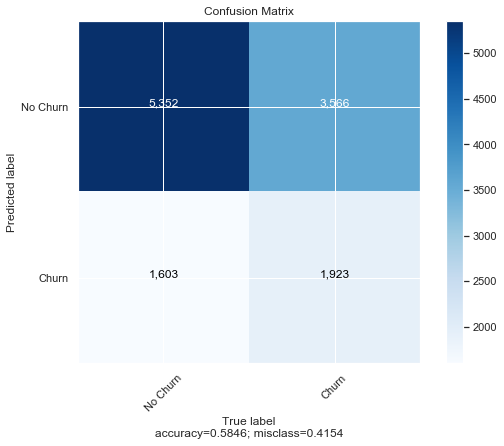

              precision    recall  f1-score   support

    No Churn       0.77      0.60      0.67      8918
       Churn       0.35      0.55      0.43      3526

    accuracy                           0.58     12444
   macro avg       0.56      0.57      0.55     12444
weighted avg       0.65      0.58      0.60     12444



In [402]:
knn_under2 = KNeighborsClassifier(**knn_under.best_params_)
knn_under2.fit(X_train_under, y_train_under)
preds = knn_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

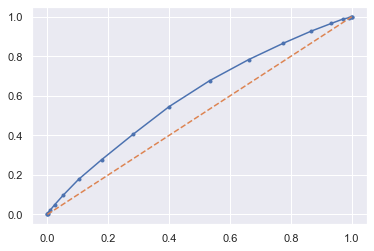

ROC AUC: 0.5980607232951336


In [403]:
model_scores = model_scores.append({'Model': 'knn_under2', 'Score': plot_roc_auc(knn_under2, X_test, y_test)}, ignore_index=True)

In [404]:
hyper_para = {'leaf_size': range(15, 25, 5), 'n_neighbors': range(20, 30, 2), 'p': [1], 'n_jobs': [num_jobs // 2]}

knn_under3 = GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
knn_under3.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   53.3s
[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:  5.5min remaining:   28.8s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:  5.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'leaf_size': range(15, 25, 5), 'n_jobs': [4],
                         'n_neighbors': range(20, 30, 2), 'p': [1]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', verbose=5)

In [405]:
knn_under3.best_score_, knn_under3.best_params_

(0.6001036571468915, {'leaf_size': 20, 'n_jobs': 4, 'n_neighbors': 28, 'p': 1})

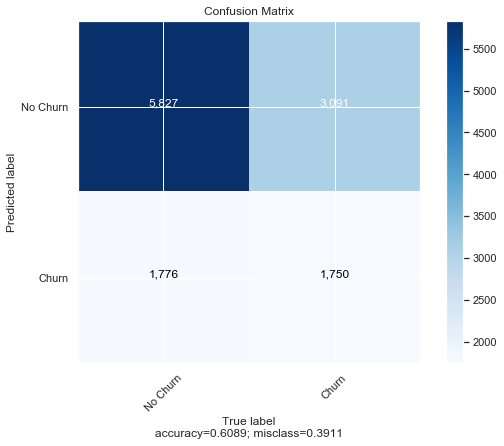

              precision    recall  f1-score   support

    No Churn       0.77      0.65      0.71      8918
       Churn       0.36      0.50      0.42      3526

    accuracy                           0.61     12444
   macro avg       0.56      0.57      0.56     12444
weighted avg       0.65      0.61      0.62     12444



In [406]:
knn_under4 = KNeighborsClassifier(**knn_under3.best_params_)
knn_under4.fit(X_train_under, y_train_under)
preds = knn_under4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

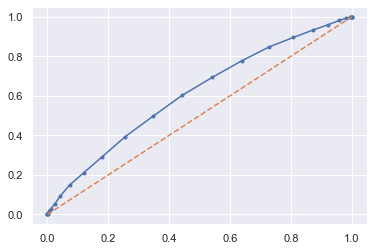

ROC AUC: 0.6084571892621716


In [407]:
model_scores = model_scores.append({'Model': 'knn_under4', 'Score': plot_roc_auc(knn_under4, X_test, y_test)}, ignore_index=True)

In [408]:
hyper_para = {'leaf_size': range(15, 30, 5), 'n_neighbors': range(19, 35, 1), 'p': [1, 2], 'n_jobs': [num_jobs // 2]}

knn_under5 = GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
knn_under5.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   20.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 11.8min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 21.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 34.2min
[Parallel(n_jobs=8)]: Done 480 out of 480 | elapsed: 37.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'leaf_size': range(15, 30, 5), 'n_jobs': [4],
                         'n_neighbors': range(19, 35), 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', verbose=5)

In [409]:
knn_under5.best_score_, knn_under5.best_params_

(0.6041577126168585, {'leaf_size': 20, 'n_jobs': 4, 'n_neighbors': 34, 'p': 1})

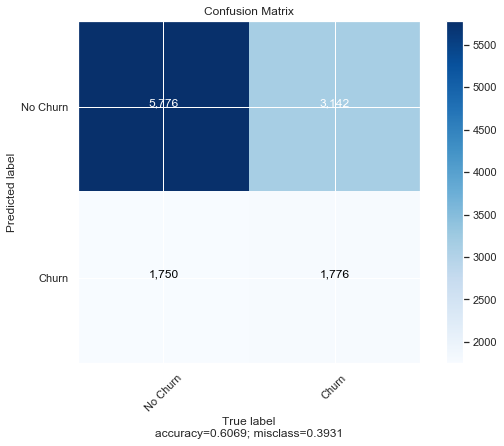

              precision    recall  f1-score   support

    No Churn       0.77      0.65      0.70      8918
       Churn       0.36      0.50      0.42      3526

    accuracy                           0.61     12444
   macro avg       0.56      0.58      0.56     12444
weighted avg       0.65      0.61      0.62     12444



In [410]:
knn_under6 = KNeighborsClassifier(**knn_under5.best_params_)
knn_under6.fit(X_train_under, y_train_under)
preds = knn_under6.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

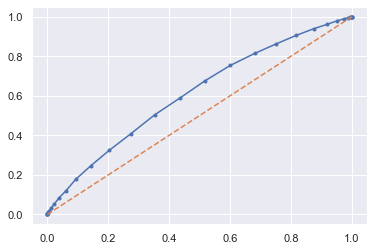

ROC AUC: 0.609849356022102


In [411]:
model_scores = model_scores.append({'Model': 'knn_under6', 'Score': plot_roc_auc(knn_under6, X_test, y_test)}, ignore_index=True)

#KNN Classification Oversampling

In [412]:
hyper_para = {'leaf_size': range(5, 15, 5), 'n_neighbors': range(5, 16, 1), 'p': [1], 'n_jobs': [num_jobs // 2]}

knn_over = GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
knn_over.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 23.4min
[Parallel(n_jobs=8)]: Done 110 out of 110 | elapsed: 43.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'leaf_size': range(5, 15, 5), 'n_jobs': [4],
                         'n_neighbors': range(5, 16), 'p': [1]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', verbose=5)

In [413]:
knn_over.best_score_, knn_over.best_params_

(0.7293786134009683, {'leaf_size': 10, 'n_jobs': 4, 'n_neighbors': 5, 'p': 1})

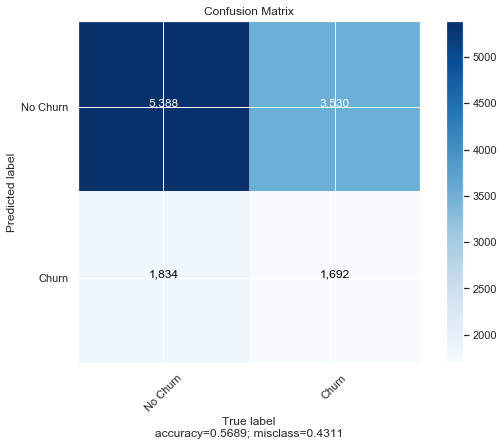

              precision    recall  f1-score   support

    No Churn       0.75      0.60      0.67      8918
       Churn       0.32      0.48      0.39      3526

    accuracy                           0.57     12444
   macro avg       0.54      0.54      0.53     12444
weighted avg       0.63      0.57      0.59     12444



In [414]:
knn_over2 = KNeighborsClassifier(**knn_over.best_params_)
knn_over2.fit(X_train_over, y_train_over)
preds = knn_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

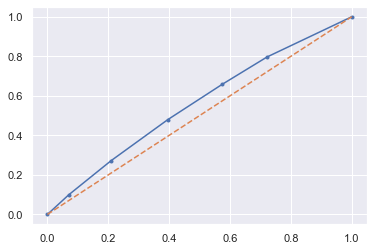

ROC AUC: 0.5581987019312659


In [415]:
model_scores = model_scores.append({'Model': 'knn_over2', 'Score': plot_roc_auc(knn_over2, X_test, y_test)}, ignore_index=True)

#KNN Classification SMOTE Oversampling

In [416]:
hyper_para = {'leaf_size': range(10, 25, 5), 'n_neighbors': range(15, 25, 2), 'p': [1], 'n_jobs': [num_jobs // 2]}

knn_smote = GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
knn_smote.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 25.1min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 33.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'leaf_size': range(10, 25, 5), 'n_jobs': [4],
                         'n_neighbors': range(15, 25, 2), 'p': [1]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', verbose=5)

In [417]:
knn_smote.best_score_, knn_smote.best_params_

(0.7214684287982005, {'leaf_size': 15, 'n_jobs': 4, 'n_neighbors': 15, 'p': 1})

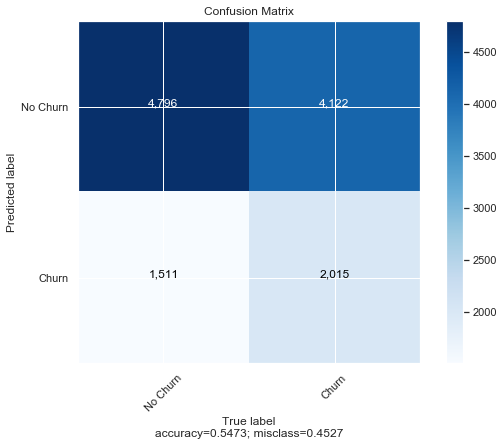

              precision    recall  f1-score   support

    No Churn       0.76      0.54      0.63      8918
       Churn       0.33      0.57      0.42      3526

    accuracy                           0.55     12444
   macro avg       0.54      0.55      0.52     12444
weighted avg       0.64      0.55      0.57     12444



In [418]:
knn_smote2 = KNeighborsClassifier(**knn_smote.best_params_)
knn_smote2.fit(X_train_smote, y_train_smote)
preds = knn_smote2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

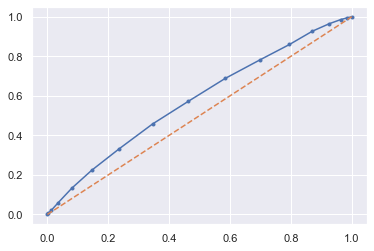

ROC AUC: 0.5781840776052869


In [419]:
model_scores = model_scores.append({'Model': 'knn_smote2', 'Score': plot_roc_auc(knn_smote2, X_test, y_test)}, ignore_index=True)

#Decision Tree Undersampling

In [420]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2'], 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_under = GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
dec_under.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   15.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=8,
             param_grid={'criterion': ['entropy', 'gini'],
                      

In [421]:
dec_under.best_score_, dec_under.best_params_

(0.6000044292285709,
 {'criterion': 'gini',
  'max_depth': 9,
  'max_features': 'sqrt',
  'random_state': 100})

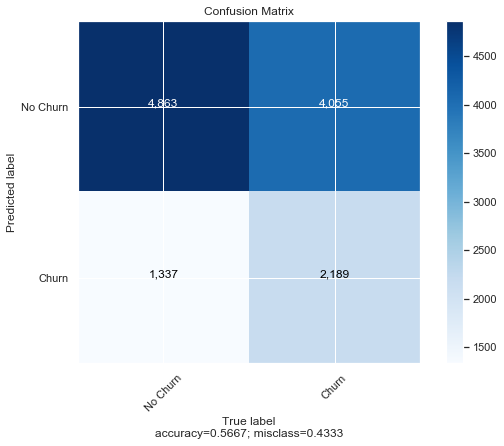

              precision    recall  f1-score   support

    No Churn       0.78      0.55      0.64      8918
       Churn       0.35      0.62      0.45      3526

    accuracy                           0.57     12444
   macro avg       0.57      0.58      0.55     12444
weighted avg       0.66      0.57      0.59     12444



In [422]:
dec_under2 = tree.DecisionTreeClassifier(**dec_under.best_params_)
dec_under2.fit(X_train_under, y_train_under)
preds = dec_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

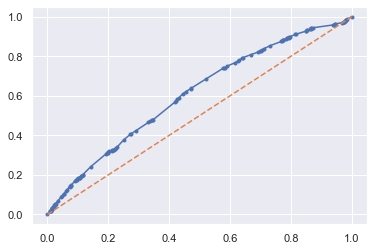

ROC AUC: 0.6081544530573318


In [423]:
model_scores = model_scores.append({'Model': 'dec_under2', 'Score': plot_roc_auc(dec_under2, X_test, y_test)}, ignore_index=True)

In [424]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(5, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_under3 = GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
dec_under3.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   25.3s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:   36.6s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:   51.4s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 2162 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 3026 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 3512 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed:  3.0min f

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=8,
             param_grid={'criterion': ['entropy', 'gini'],
                      

In [425]:
dec_under3.best_score_, dec_under3.best_params_

(0.6240631590378236,
 {'criterion': 'gini',
  'max_depth': 8,
  'max_features': 23,
  'random_state': 100})

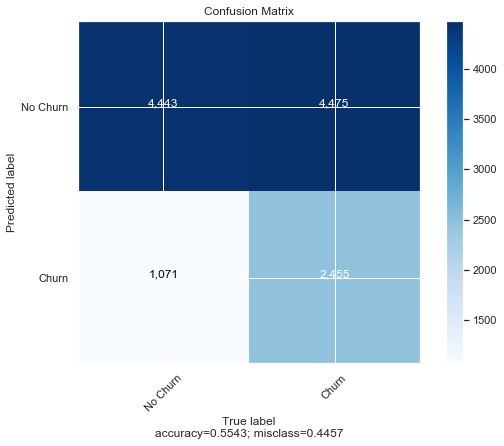

              precision    recall  f1-score   support

    No Churn       0.81      0.50      0.62      8918
       Churn       0.35      0.70      0.47      3526

    accuracy                           0.55     12444
   macro avg       0.58      0.60      0.54     12444
weighted avg       0.68      0.55      0.57     12444



In [426]:
dec_under4 = tree.DecisionTreeClassifier(**dec_under3.best_params_)
dec_under4.fit(X_train_under, y_train_under)
preds = dec_under4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

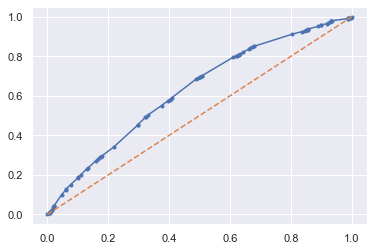

ROC AUC: 0.6266962227349786


In [427]:
model_scores = model_scores.append({'Model': 'dec_under4', 'Score': plot_roc_auc(dec_under4, X_test, y_test)}, ignore_index=True)

#Decision Tree Oversampling

In [428]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(5, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_over = GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
dec_over.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   10.7s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   20.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   34.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   52.5s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 2162 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 3026 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 3512 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed:  6.7min f

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=8,
             param_grid={'criterion': ['entropy', 'gini'],
                      

In [429]:
dec_over.best_score_, dec_over.best_params_

(0.8008451676866086,
 {'criterion': 'gini',
  'max_depth': 19,
  'max_features': 18,
  'random_state': 100})

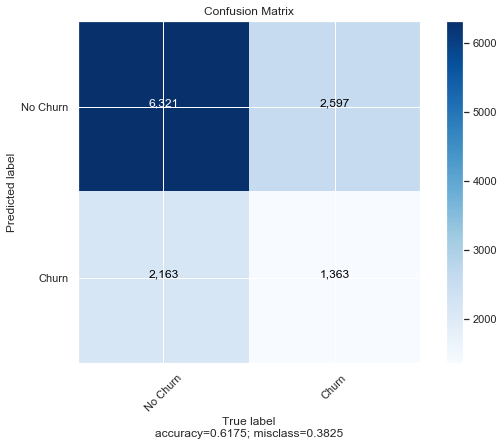

              precision    recall  f1-score   support

    No Churn       0.75      0.71      0.73      8918
       Churn       0.34      0.39      0.36      3526

    accuracy                           0.62     12444
   macro avg       0.54      0.55      0.55     12444
weighted avg       0.63      0.62      0.62     12444



In [430]:
dec_over2 = tree.DecisionTreeClassifier(**dec_over.best_params_)
dec_over2.fit(X_train_over, y_train_over)
preds = dec_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

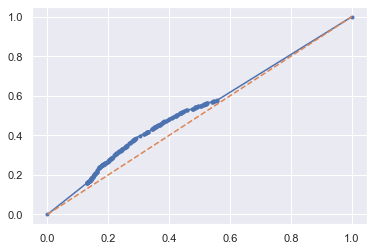

ROC AUC: 0.536347966224568


In [431]:
model_scores = model_scores.append({'Model': 'dec_over2', 'Score': plot_roc_auc(dec_over2, X_test, y_test)}, ignore_index=True)

#Decision Tree SMOTE Oversampling

In [432]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(5, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_smote = GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
dec_smote.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   19.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   34.4s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   54.3s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 2162 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 3026 tasks      | elapsed:  5.3min
[Parallel(n_jobs=8)]: Done 3512 tasks      | elapsed:  6.3min
[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed:  6.5min f

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=8,
             param_grid={'criterion': ['entropy', 'gini'],
                      

In [433]:
dec_smote.best_score_, dec_smote.best_params_

(0.8019104643465894,
 {'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 21,
  'random_state': 100})

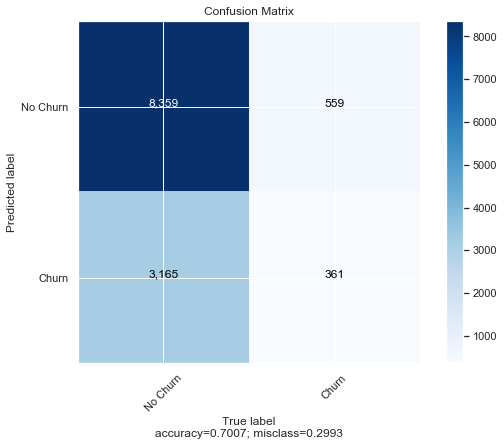

              precision    recall  f1-score   support

    No Churn       0.73      0.94      0.82      8918
       Churn       0.39      0.10      0.16      3526

    accuracy                           0.70     12444
   macro avg       0.56      0.52      0.49     12444
weighted avg       0.63      0.70      0.63     12444



In [434]:
dec_smote2 = tree.DecisionTreeClassifier(**dec_smote.best_params_)
dec_smote2.fit(X_train_smote, y_train_smote)
preds = dec_smote2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

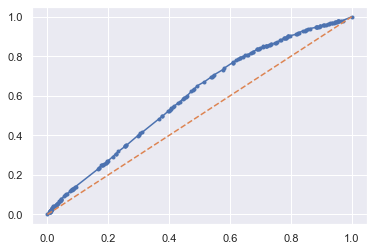

ROC AUC: 0.5972735201178139


In [435]:
model_scores = model_scores.append({'Model': 'dec_smote2', 'Score': plot_roc_auc(dec_smote2, X_test, y_test)}, ignore_index=True)

#Random Forest Undersampling

In [436]:
hyper_para = {'criterion': ['gini'], 'max_features': range(10, 15, 1), 'max_depth': range(15, 25, 2), 'random_state': [100], 'n_estimators': [500], 'n_jobs': [num_jobs // 2]}

forest_under = GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
forest_under.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 21.5min
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed: 48.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [437]:
forest_under.best_score_, forest_under.best_params_

(0.8746084554829429,
 {'criterion': 'gini',
  'max_depth': 23,
  'max_features': 11,
  'n_estimators': 500,
  'n_jobs': 4,
  'random_state': 100})

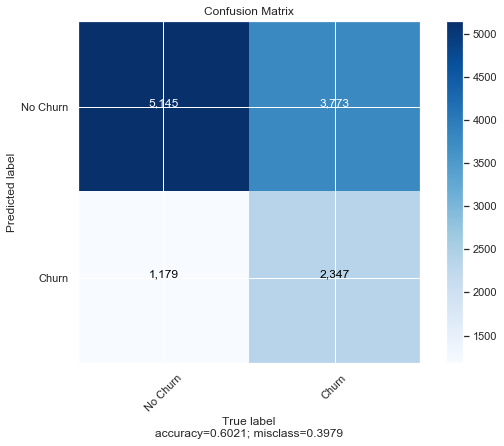

              precision    recall  f1-score   support

    No Churn       0.81      0.58      0.68      8918
       Churn       0.38      0.67      0.49      3526

    accuracy                           0.60     12444
   macro avg       0.60      0.62      0.58     12444
weighted avg       0.69      0.60      0.62     12444



In [438]:
forest_under2 = ensemble.RandomForestClassifier(**forest_under.best_params_)
forest_under2.fit(X_train_under, y_train_under)
preds = forest_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

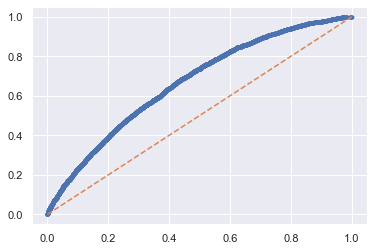

ROC AUC: 0.6682339706434768


In [439]:
model_scores = model_scores.append({'Model': 'forest_under2', 'Score': plot_roc_auc(forest_under2, X_test, y_test)}, ignore_index=True)

In [440]:
hyper_para = {'criterion': ['gini'], 'max_features': range(10, 15, 1), 'max_depth': range(25, 35, 2), 'random_state': [100], 'n_estimators': [500], 'n_jobs': [num_jobs // 2]}

forest_under3 = GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
forest_under3.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 24.1min
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed: 52.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [441]:
forest_under3.best_score_, forest_under3.best_params_

(0.8758578961008793,
 {'criterion': 'gini',
  'max_depth': 33,
  'max_features': 14,
  'n_estimators': 500,
  'n_jobs': 4,
  'random_state': 100})

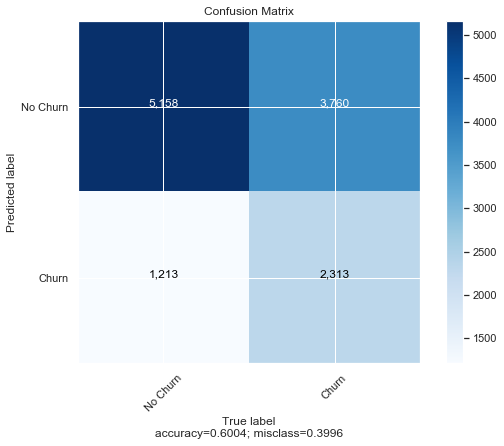

              precision    recall  f1-score   support

    No Churn       0.81      0.58      0.67      8918
       Churn       0.38      0.66      0.48      3526

    accuracy                           0.60     12444
   macro avg       0.60      0.62      0.58     12444
weighted avg       0.69      0.60      0.62     12444



In [442]:
forest_under4 = ensemble.RandomForestClassifier(**forest_under3.best_params_)
forest_under4.fit(X_train_under, y_train_under)
preds = forest_under4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

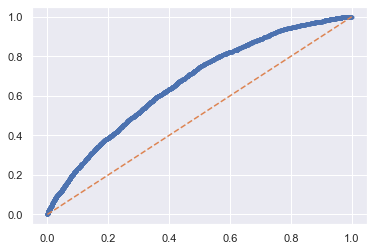

ROC AUC: 0.6673767401408713


In [443]:
model_scores = model_scores.append({'Model': 'forest_under4', 'Score': plot_roc_auc(forest_under4, X_test, y_test)}, ignore_index=True)

#Random Forest Oversampling

In [444]:
hyper_para = {'criterion': ['gini'], 'max_features': range(10, 15, 1), 'max_depth': range(20, 30, 2), 'random_state': [100], 'n_estimators': [500], 'n_jobs': [num_jobs // 2]}

forest_over = GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
forest_over.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 24.3min
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed: 54.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [445]:
forest_over.best_score_, forest_over.best_params_

(0.9544720978589503,
 {'criterion': 'gini',
  'max_depth': 28,
  'max_features': 10,
  'n_estimators': 500,
  'n_jobs': 4,
  'random_state': 100})

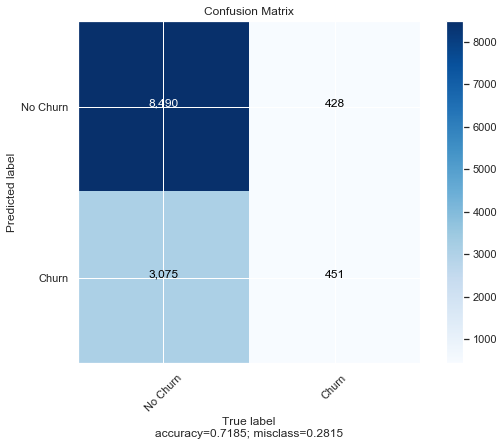

              precision    recall  f1-score   support

    No Churn       0.73      0.95      0.83      8918
       Churn       0.51      0.13      0.20      3526

    accuracy                           0.72     12444
   macro avg       0.62      0.54      0.52     12444
weighted avg       0.67      0.72      0.65     12444



In [446]:
forest_over2 = ensemble.RandomForestClassifier(**forest_over.best_params_)
forest_over2.fit(X_train_over, y_train_over)
preds = forest_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

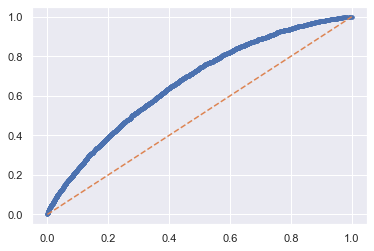

ROC AUC: 0.6674764543454277


In [447]:
model_scores = model_scores.append({'Model': 'forest_over2', 'Score': plot_roc_auc(forest_over2, X_test, y_test)}, ignore_index=True)

In [448]:
hyper_para = {'criterion': ['gini'], 'max_features': range(14, 20, 1), 'max_depth': range(10, 20, 2), 'random_state': [100], 'n_estimators': [500], 'n_jobs': [num_jobs // 2]}

forest_over3 = GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring=f1_scorer, n_jobs=num_jobs, return_train_score=True, verbose=5, refit='f1_scorer', cv=5)
forest_over3.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 19.7min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 64.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [449]:
forest_over3.best_score_, forest_over3.best_params_

(0.8679029299282066,
 {'criterion': 'gini',
  'max_depth': 18,
  'max_features': 17,
  'n_estimators': 500,
  'n_jobs': 4,
  'random_state': 100})

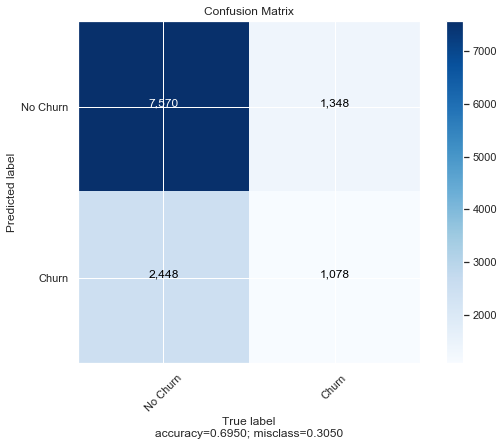

              precision    recall  f1-score   support

    No Churn       0.76      0.85      0.80      8918
       Churn       0.44      0.31      0.36      3526

    accuracy                           0.69     12444
   macro avg       0.60      0.58      0.58     12444
weighted avg       0.67      0.69      0.68     12444



In [450]:
forest_over4 = ensemble.RandomForestClassifier(**forest_over3.best_params_)
forest_over4.fit(X_train_over, y_train_over)
preds = forest_over4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

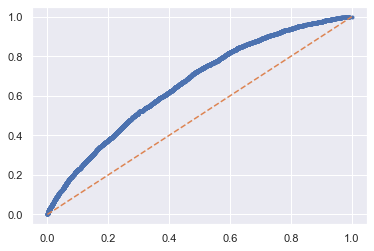

ROC AUC: 0.6611619740302297


In [451]:
model_scores = model_scores.append({'Model': 'forest_over4', 'Score': plot_roc_auc(forest_over4, X_test, y_test)}, ignore_index=True)

#Random Forest SMOTE Oversampling

In [452]:
hyper_para = {'criterion': ['gini'], 'max_features': range(16, 20, 1), 'max_depth': range(10, 20, 2), 'random_state': [100], 'n_estimators': [500], 'n_jobs': [num_jobs // 2]}

forest_smote = GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
forest_smote.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 25.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed: 47.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [453]:
forest_smote.best_score_, forest_smote.best_params_

(0.8727530602945912,
 {'criterion': 'gini',
  'max_depth': 18,
  'max_features': 17,
  'n_estimators': 500,
  'n_jobs': 4,
  'random_state': 100})

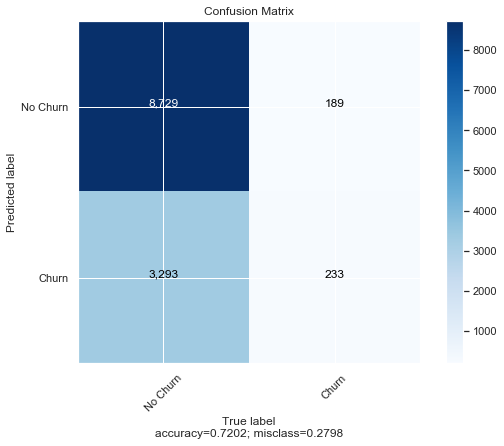

              precision    recall  f1-score   support

    No Churn       0.73      0.98      0.83      8918
       Churn       0.55      0.07      0.12      3526

    accuracy                           0.72     12444
   macro avg       0.64      0.52      0.48     12444
weighted avg       0.68      0.72      0.63     12444



In [454]:
forest_smote2 = ensemble.RandomForestClassifier(**forest_smote.best_params_)
forest_smote2.fit(X_train_smote, y_train_smote)
preds = forest_smote2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

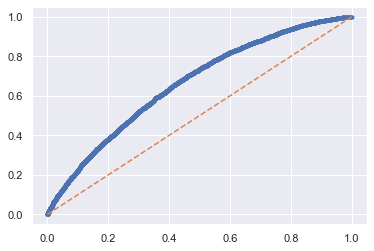

ROC AUC: 0.6632796168837471


In [455]:
model_scores = model_scores.append({'Model': 'forest_smote2', 'Score': plot_roc_auc(forest_smote2, X_test, y_test)}, ignore_index=True)

#EDA Outliers
This time, we're going to winsorize our outliers in the dataset and test our models and compare to see if there's any improvements.

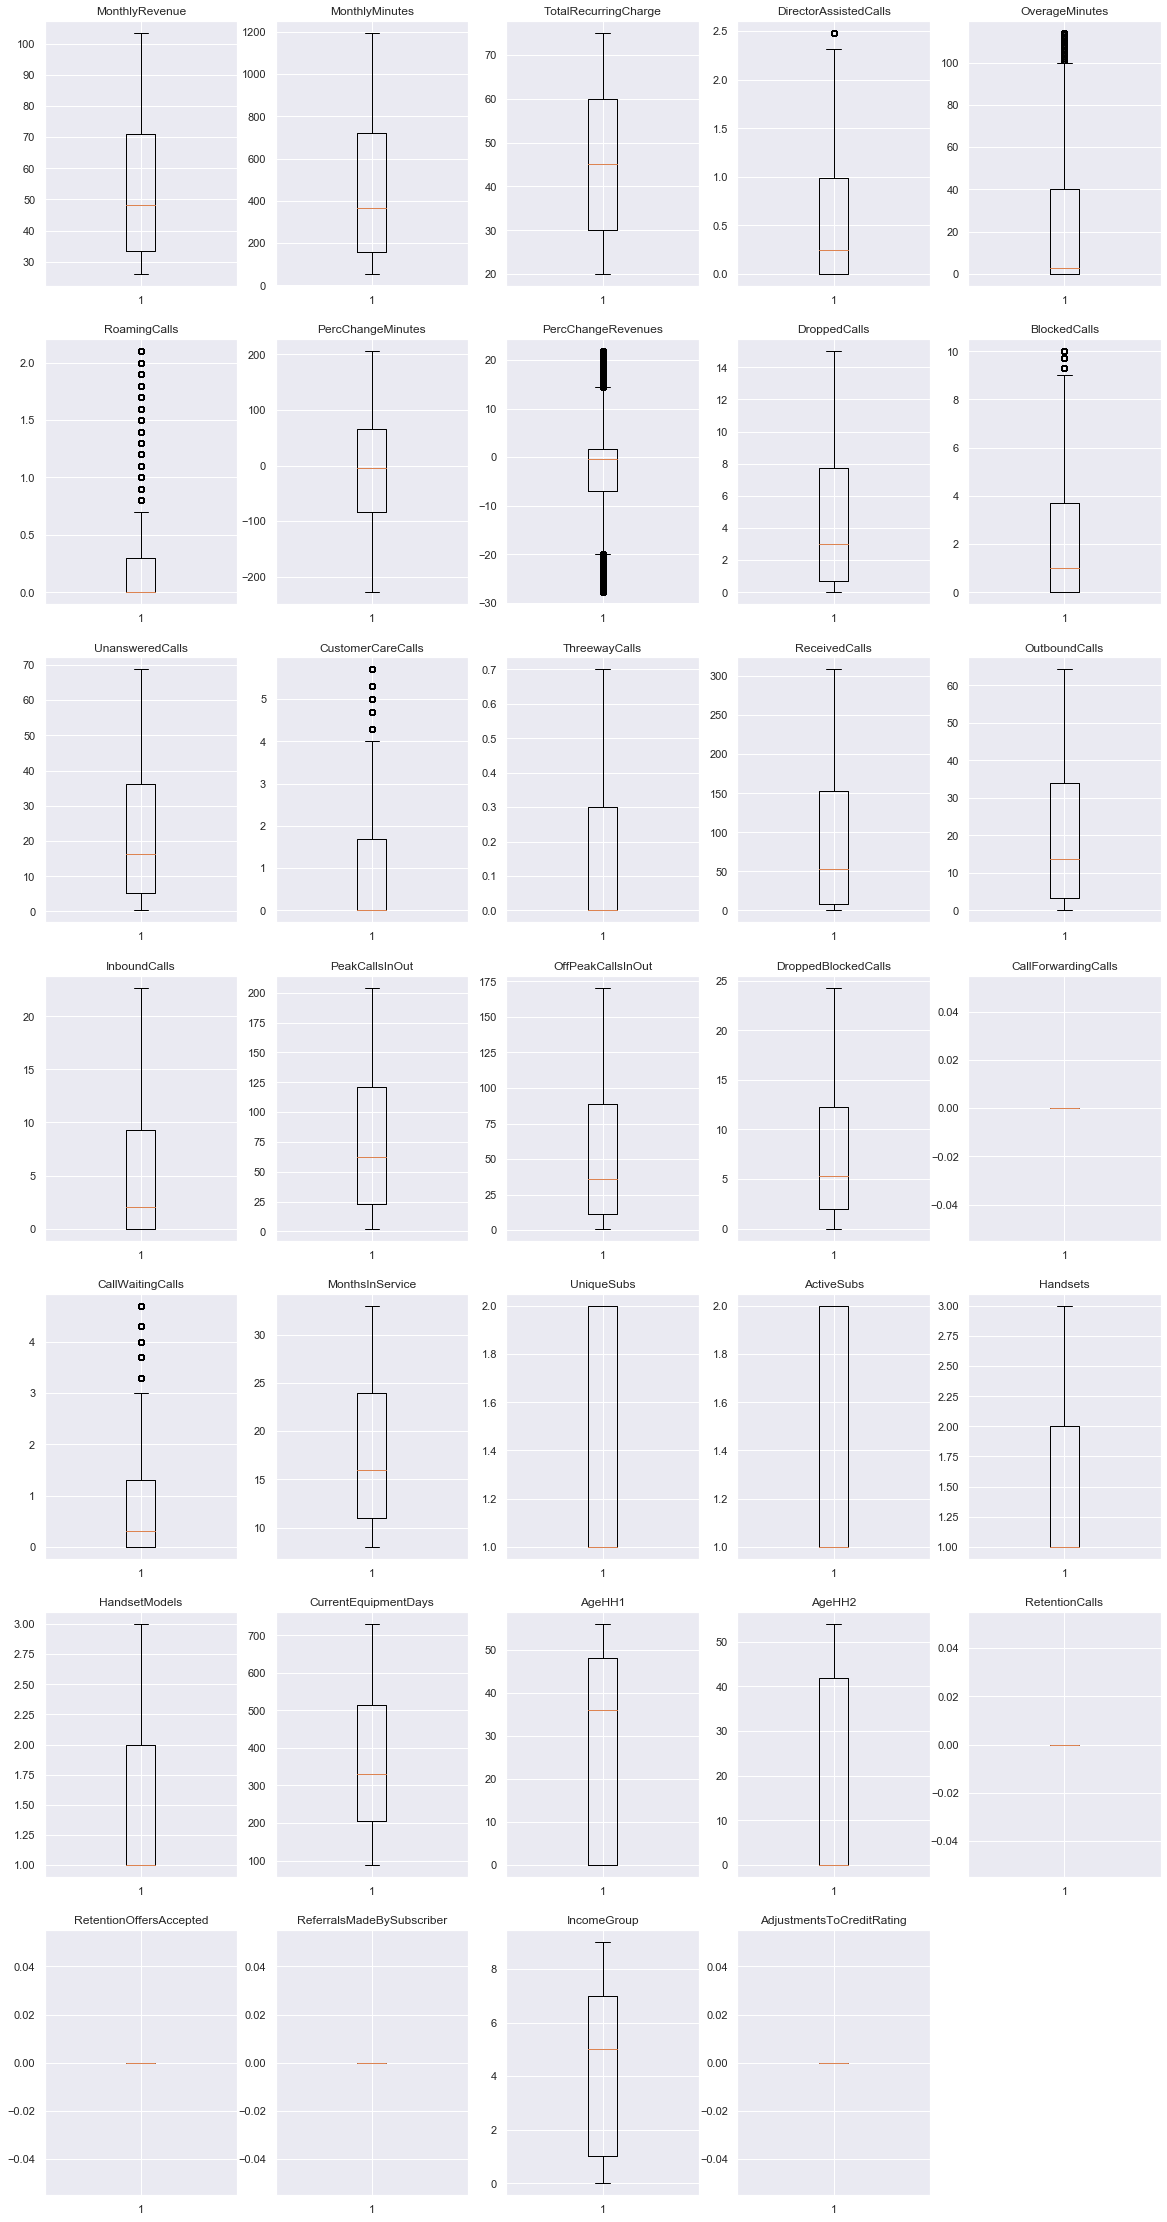

In [456]:
features_cleaned = features_df.copy()

numeric_columns = features_cleaned.select_dtypes(['int64', 'float64']).columns
for col in numeric_columns:
  features_cleaned[col] = winsorize(features_cleaned[col], (0.10, 0.10))

plt.figure(figsize=(20,40))
for i, col in enumerate(numeric_columns):
  plt.subplot(math.ceil(len(numeric_columns)/5), 5, i+1)
  plt.boxplot(features_cleaned[col])
  plt.title(col)

plt.show()

In [457]:
#Feature engineer categorical features again
cred_rating = np.array(features_cleaned['CreditRating']).reshape(-1,1)
encoder = OrdinalEncoder(categories=[['7-Lowest', '6-VeryLow', '5-Low', '4-Medium', '3-Good', '2-High', '1-Highest']], dtype='int64')

data_winsorize = features_df.copy()
data_winsorize['Cred_Rating'] = encoder.fit_transform(cred_rating)
data_winsorize.drop('CreditRating', axis=1, inplace=True)

obj_columns = data_winsorize.select_dtypes('object').columns

for col in obj_columns:
  if col != 'Churn':
    data_winsorize = pd.concat([data_winsorize, pd.get_dummies(data_winsorize[col], prefix=col, drop_first=False)], axis=1)
    data_winsorize.drop(col, axis=1, inplace=True)

data_winsorize.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49776 entries, 0 to 51043
Data columns (total 83 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        49776 non-null  object 
 1   MonthlyRevenue               49776 non-null  float64
 2   MonthlyMinutes               49776 non-null  float64
 3   TotalRecurringCharge         49776 non-null  float64
 4   DirectorAssistedCalls        49776 non-null  float64
 5   OverageMinutes               49776 non-null  float64
 6   RoamingCalls                 49776 non-null  float64
 7   PercChangeMinutes            49776 non-null  float64
 8   PercChangeRevenues           49776 non-null  float64
 9   DroppedCalls                 49776 non-null  float64
 10  BlockedCalls                 49776 non-null  float64
 11  UnansweredCalls              49776 non-null  float64
 12  CustomerCareCalls            49776 non-null  float64
 13  ThreewayCalls   

In [458]:
data_winsorize.loc[(data_winsorize.Churn == 'Yes'), 'Churn'] = 1
data_winsorize.loc[(data_winsorize.Churn == 'No'), 'Churn'] = 0

X_win = data_winsorize.drop('Churn', axis=1)
y_win = data_winsorize['Churn'].astype('int64')

X_win_train, X_win_test, y_win_train, y_win_test = train_test_split(X_win, y_win, random_state=50)

merge_df = pd.concat([X_win_train, y_win_train], axis=1)

churn = merge_df[merge_df['Churn'] == 1]
not_churn = merge_df[merge_df['Churn'] == 0]

print('Training set Churn:',churn.shape[0])
print('Training set Not Churn:',not_churn.shape[0])

Training set Churn: 10731
Training set Not Churn: 26601


In [459]:
#Winsorized undersampled training dataset
not_churn_under = resample(not_churn, replace=False, n_samples = len(churn), random_state=150)
undersampled = pd.concat([not_churn_under, churn])

X_win_train_under = undersampled.drop('Churn', axis=1)
y_win_train_under = undersampled['Churn']

undersampled.Churn.value_counts()

1    10731
0    10731
Name: Churn, dtype: int64

In [460]:
#Winsorized oversampled training dataset
churn_over = resample(churn, replace=True, n_samples=len(not_churn), random_state=125)

oversampled = pd.concat([not_churn, churn_over])

X_win_train_over = oversampled.drop('Churn', axis=1)
y_win_train_over = oversampled['Churn']

oversampled['Churn'].value_counts()

1    26601
0    26601
Name: Churn, dtype: int64

In [461]:
#SMOTE oversampled training dataset
sm = SMOTE(random_state=50, n_jobs=-1)

X_win_train_smote, y_win_train_smote = sm.fit_sample(X_win_train, y_win_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Logistic Regression Undersampling with Winsorized Outliers

In [462]:
hyper_para = {'penalty': ['l2', 'l1'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}

lr_win_under = GridSearchCV(LogisticRegression(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
lr_win_under.fit(X_win_train_under, y_win_train_under)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   49.9s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:  5.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': range(100, 500, 100),
                         'penalty': ['l2', 'l1'], 'random_state': [50],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', 

In [463]:
lr_win_under.best_score_, lr_win_under.best_params_

(0.6107082979440892,
 {'C': 0.1,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

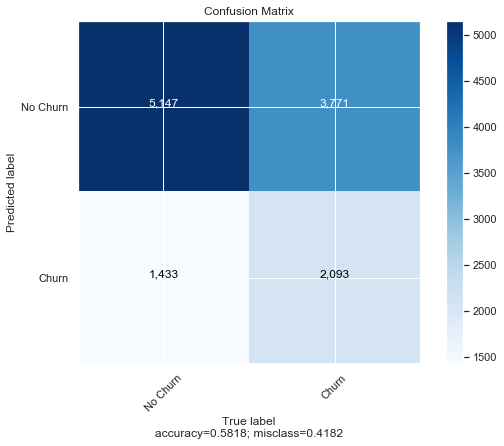

              precision    recall  f1-score   support

    No Churn       0.78      0.58      0.66      8918
       Churn       0.36      0.59      0.45      3526

    accuracy                           0.58     12444
   macro avg       0.57      0.59      0.56     12444
weighted avg       0.66      0.58      0.60     12444



In [464]:
lr_win_under2 = LogisticRegression(**lr_win_under.best_params_)
lr_win_under2.fit(X_win_train_under, y_win_train_under)
preds = lr_win_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

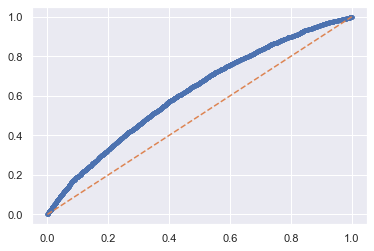

ROC AUC: 0.6169464918726961


In [465]:
model_scores = model_scores.append({'Model': 'lr_win_under2', 'Score': plot_roc_auc(lr_win_under2, X_test, y_test)}, ignore_index=True)

#Logistic Regression Oversampling with Winsorized Outliers

In [466]:
hyper_para = {'penalty': ['l2', 'l1'], 'solver': ['liblinear'], 'max_iter': range(100, 1000, 100), 'C': [0.001, 0.01, 0.1, 1], 'random_state': [50]}

lr_win_over = GridSearchCV(LogisticRegression(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
lr_win_over.fit(X_win_train_over, y_win_train_over)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  5.2min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 13.7min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 22.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'max_iter': range(100, 1000, 100),
                         'penalty': ['l2', 'l1'], 'random_state': [50],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', verbose

In [467]:
lr_win_over.best_score_, lr_win_over.best_params_

(0.6159556431477566,
 {'C': 0.1,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

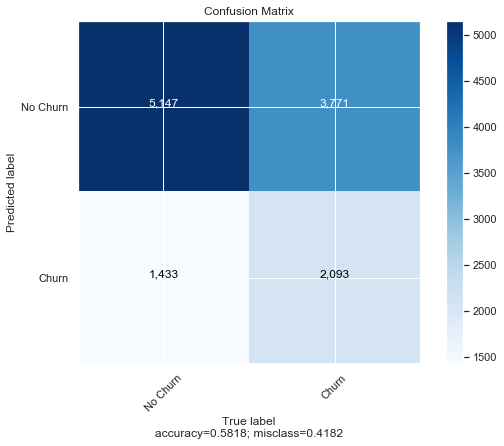

              precision    recall  f1-score   support

    No Churn       0.78      0.58      0.66      8918
       Churn       0.36      0.59      0.45      3526

    accuracy                           0.58     12444
   macro avg       0.57      0.59      0.56     12444
weighted avg       0.66      0.58      0.60     12444



In [468]:
lr_win_over2 = LogisticRegression(**lr_win_over.best_params_)
lr_win_over2.fit(X_win_train_under, y_win_train_under)
preds = lr_win_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

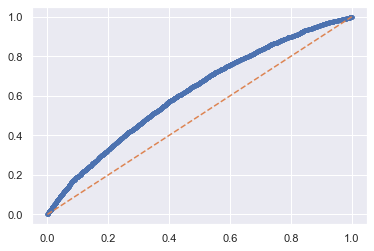

ROC AUC: 0.6169464918726961


In [469]:
model_scores = model_scores.append({'Model': 'lr_win_over2', 'Score': plot_roc_auc(lr_win_over2, X_test, y_test)}, ignore_index=True)

#Gradient Boost Undersampling with Winsorized Outliers

In [470]:
hyper_para = {'n_estimators': range(90, 200, 10), 'max_depth': range(4, 8, 1), 'random_state': [50], 'loss': ['deviance'], 'max_features': [15, 25, 2], 'subsample': [0.8], 'learning_rate': [0.1]}

gradboost_win_under = GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
gradboost_win_under.fit(X_win_train_under, y_win_train_under)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   57.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  5.3min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 14.3min
[Parallel(n_jobs=8)]: Done 660 out of 660 | elapsed: 14.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [471]:
gradboost_win_under.best_score_, gradboost_win_under.best_params_

(0.6686996936821595,
 {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 4,
  'max_features': 25,
  'n_estimators': 170,
  'random_state': 50,
  'subsample': 0.8})

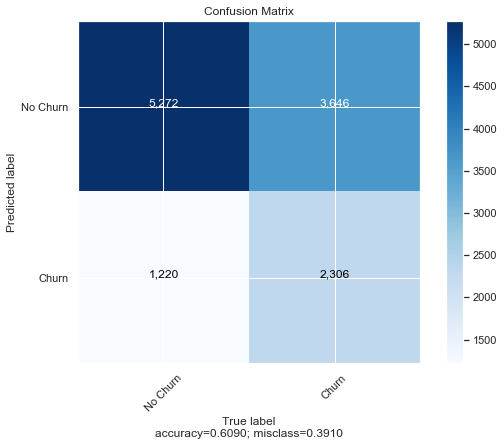

              precision    recall  f1-score   support

    No Churn       0.81      0.59      0.68      8918
       Churn       0.39      0.65      0.49      3526

    accuracy                           0.61     12444
   macro avg       0.60      0.62      0.59     12444
weighted avg       0.69      0.61      0.63     12444



In [472]:
gradboost_win_under2 = ensemble.GradientBoostingClassifier(**gradboost_win_under.best_params_)
gradboost_win_under2.fit(X_win_train_under, y_win_train_under)
preds = gradboost_win_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

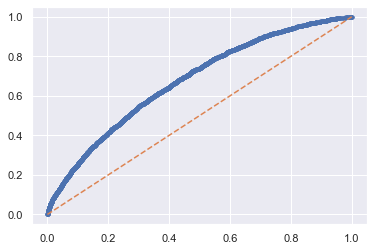

ROC AUC: 0.6767090896994702


In [473]:
model_scores = model_scores.append({'Model': 'gradboost_win_under2', 'Score': plot_roc_auc(gradboost_win_under2, X_test, y_test)}, ignore_index=True)

#Gradient Boost Oversampling with Winsorized Outliers

In [474]:
hyper_para = {'n_estimators': [190], 'max_depth': [5], 'random_state': [50], 'loss': ['deviance'], 'max_features': [35], 'subsample': [0.6, 0.7, 0.8, 0.9], 'learning_rate': np.arange(0.05, 0.2, 0.05)}

gradboost_win_over = GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
gradboost_win_over.fit(X_win_train_over, y_win_train_over)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   54.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  7.9min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 10.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [475]:
gradboost_win_over.best_score_, gradboost_win_over.best_params_

(0.7998090273912792,
 {'learning_rate': 0.2,
  'loss': 'deviance',
  'max_depth': 5,
  'max_features': 35,
  'n_estimators': 190,
  'random_state': 50,
  'subsample': 0.9})

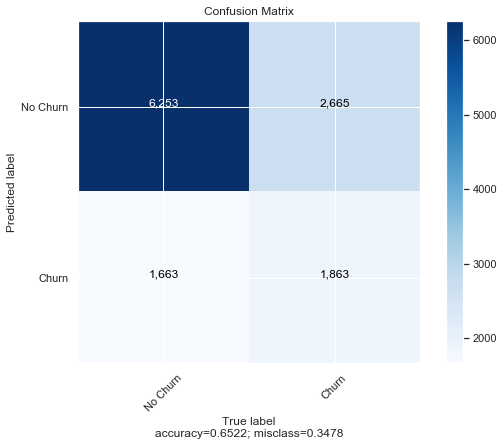

              precision    recall  f1-score   support

    No Churn       0.79      0.70      0.74      8918
       Churn       0.41      0.53      0.46      3526

    accuracy                           0.65     12444
   macro avg       0.60      0.61      0.60     12444
weighted avg       0.68      0.65      0.66     12444



In [476]:
gradboost_win_over2 = ensemble.GradientBoostingClassifier(**gradboost_win_over.best_params_)
gradboost_win_over2.fit(X_win_train_over, y_win_train_over)
preds = gradboost_win_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

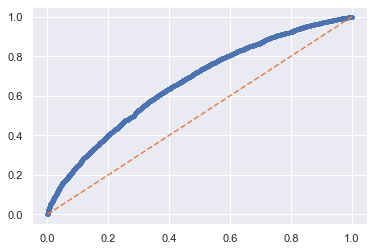

ROC AUC: 0.664635323004059


In [477]:
model_scores = model_scores.append({'Model': 'gradboost_win_over2', 'Score': plot_roc_auc(gradboost_win_over2, X_test, y_test)}, ignore_index=True)

#KNN Undersampling with Winsorized Outliers

In [478]:
hyper_para = {'leaf_size': range(15, 30, 5), 'n_neighbors': range(19, 35, 1), 'p': [1, 2], 'n_jobs': [num_jobs // 2]}

knn_win_under = GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
knn_win_under.fit(X_win_train_under, y_win_train_under)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 11.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 21.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 34.0min
[Parallel(n_jobs=8)]: Done 480 out of 480 | elapsed: 37.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'leaf_size': range(15, 30, 5), 'n_jobs': [4],
                         'n_neighbors': range(19, 35), 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', verbose=5)

In [479]:
knn_win_under.best_score_, knn_win_under.best_params_

(0.6041577126168585, {'leaf_size': 20, 'n_jobs': 4, 'n_neighbors': 34, 'p': 1})

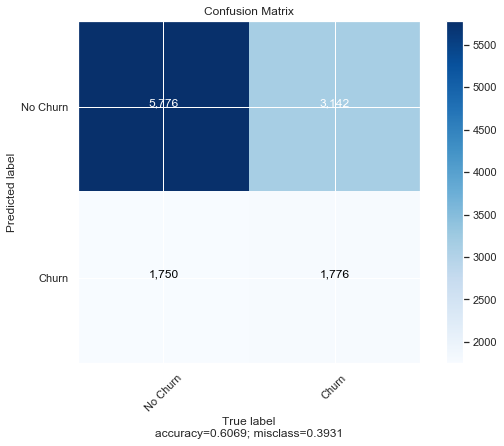

              precision    recall  f1-score   support

    No Churn       0.77      0.65      0.70      8918
       Churn       0.36      0.50      0.42      3526

    accuracy                           0.61     12444
   macro avg       0.56      0.58      0.56     12444
weighted avg       0.65      0.61      0.62     12444



In [480]:
knn_win_under2 = KNeighborsClassifier(**knn_win_under.best_params_)
knn_win_under2.fit(X_win_train_under, y_win_train_under)
preds = knn_win_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

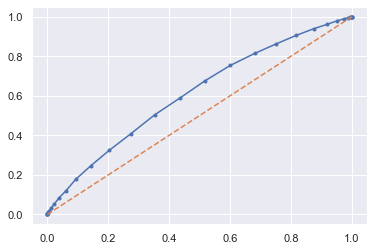

ROC AUC: 0.609849356022102


In [481]:
model_scores = model_scores.append({'Model': 'knn_win_under2', 'Score': plot_roc_auc(knn_win_under2, X_test, y_test)}, ignore_index=True)

#KNN Oversampling with Winsorized Outliers

In [482]:
hyper_para = {'leaf_size': range(15, 30, 5), 'n_neighbors': range(19, 35, 1), 'p': [1, 2], 'n_jobs': [num_jobs // 2]}

knn_win_over = GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
knn_win_over.fit(X_win_train_over, y_win_train_over)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 17.9min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 46.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 85.9min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 139.1min
[Parallel(n_jobs=8)]: Done 480 out of 480 | elapsed: 153.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=8,
             param_grid={'leaf_size': range(15, 30, 5), 'n_jobs': [4],
                         'n_neighbors': range(19, 35), 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=True,
             scoring='roc_auc', verbose=5)

In [483]:
knn_win_over.best_score_, knn_win_over.best_params_

(0.6623972141857812, {'leaf_size': 15, 'n_jobs': 4, 'n_neighbors': 19, 'p': 1})

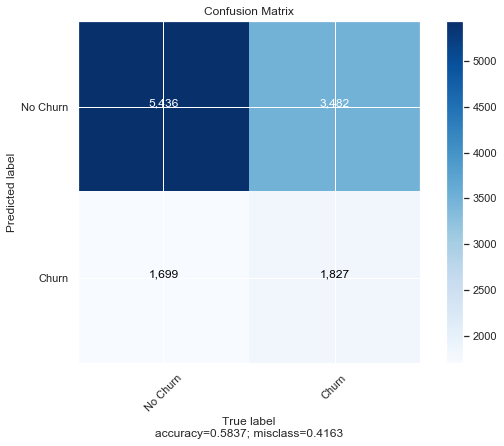

              precision    recall  f1-score   support

    No Churn       0.76      0.61      0.68      8918
       Churn       0.34      0.52      0.41      3526

    accuracy                           0.58     12444
   macro avg       0.55      0.56      0.55     12444
weighted avg       0.64      0.58      0.60     12444



In [484]:
knn_win_over2 = KNeighborsClassifier(**knn_win_over.best_params_)
knn_win_over2.fit(X_win_train_over, y_win_train_over)
preds = knn_win_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

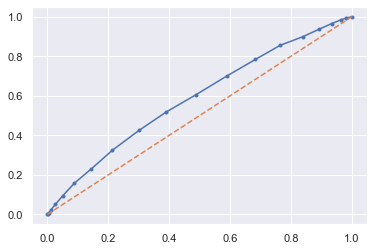

ROC AUC: 0.5884143161294236


In [485]:
model_scores = model_scores.append({'Model': 'knn_win_over2', 'Score': plot_roc_auc(knn_win_over2, X_test, y_test)}, ignore_index=True)

#Decision Tree Undersampling with Winsorized Outliers

In [486]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(15, 25, 1), 'max_depth': range(2, 10, 1), 'random_state': [100]}

dec_win_under = GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
dec_win_under.fit(X_win_train_under, y_win_train_under)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   12.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   20.5s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   29.0s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:   37.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=8,
             param_grid={'criterion': ['entropy', 'gini'],
                      

In [487]:
dec_win_under.best_score_, dec_win_under.best_params_

(0.6240631590378236,
 {'criterion': 'gini',
  'max_depth': 8,
  'max_features': 23,
  'random_state': 100})

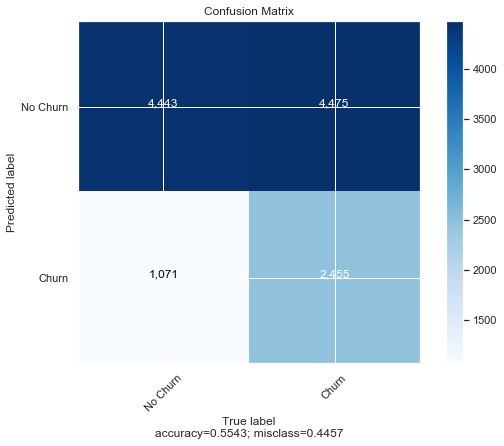

              precision    recall  f1-score   support

    No Churn       0.81      0.50      0.62      8918
       Churn       0.35      0.70      0.47      3526

    accuracy                           0.55     12444
   macro avg       0.58      0.60      0.54     12444
weighted avg       0.68      0.55      0.57     12444



In [488]:
dec_win_under2 = tree.DecisionTreeClassifier(**dec_win_under.best_params_)
dec_win_under2.fit(X_win_train_under, y_win_train_under)
preds = dec_win_under2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

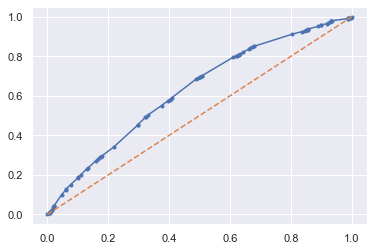

ROC AUC: 0.6266962227349786


In [489]:
model_scores = model_scores.append({'Model': 'dec_win_under2', 'Score': plot_roc_auc(dec_win_under2, X_test, y_test)}, ignore_index=True)

#Decision Tree Oversampling with Winsorized Outliers

In [490]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(15, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_win_over = GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='roc_auc', n_jobs=num_jobs, return_train_score=True, verbose=5, refit='roc_auc', cv=5)
dec_win_over.fit(X_win_train_over, y_win_train_over)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   24.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   43.8s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1800 out of 1800 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=8,
             param_grid={'criterion': ['entropy', 'gini'],
                      

In [491]:
dec_win_over.best_score_, dec_win_over.best_params_

(0.8008451676866086,
 {'criterion': 'gini',
  'max_depth': 19,
  'max_features': 18,
  'random_state': 100})

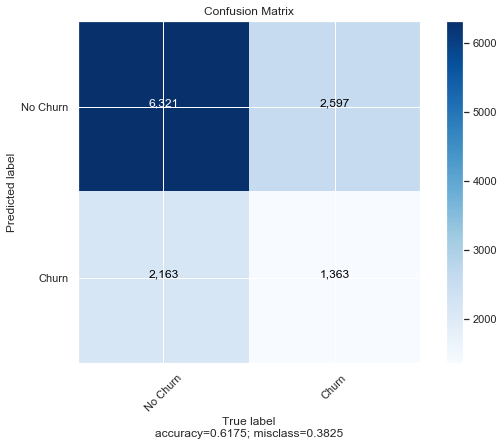

              precision    recall  f1-score   support

    No Churn       0.75      0.71      0.73      8918
       Churn       0.34      0.39      0.36      3526

    accuracy                           0.62     12444
   macro avg       0.54      0.55      0.55     12444
weighted avg       0.63      0.62      0.62     12444



In [492]:
dec_win_over2 = tree.DecisionTreeClassifier(**dec_win_over.best_params_)
dec_win_over2.fit(X_win_train_over, y_win_train_over)
preds = dec_win_over2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['No Churn', 'Churn'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

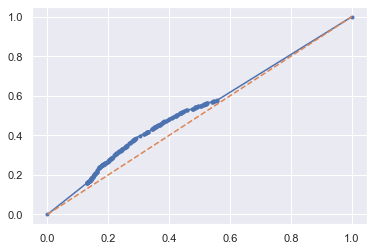

ROC AUC: 0.536347966224568


In [493]:
model_scores = model_scores.append({'Model': 'dec_win_over2', 'Score': plot_roc_auc(dec_win_over2, X_test, y_test)}, ignore_index=True)

#Best Model



In [494]:
#Sort by best ROC_AUC score
model_scores.sort_values(['Score', 'Model'], ascending=False)

,Model,Score
6,gradboost_over2,0.677226
25,gradboost_win_under2,0.676709
4,gradboost_under2,0.676709
5,gradboost_under4,0.675954
8,gradboost_smote2,0.675843
18,forest_under2,0.668234
20,forest_over2,0.667476
19,forest_under4,0.667377
26,gradboost_win_over2,0.664635
7,gradboost_over4,0.664635


It looks like the best performing models are the gradient boost models. I'm going to select the best performing gradient boost model with undersampled dataset as it is also computationally intensive due to having less datapoints. Below is a bar plot of the most important feature contributions to the target variable Churn.

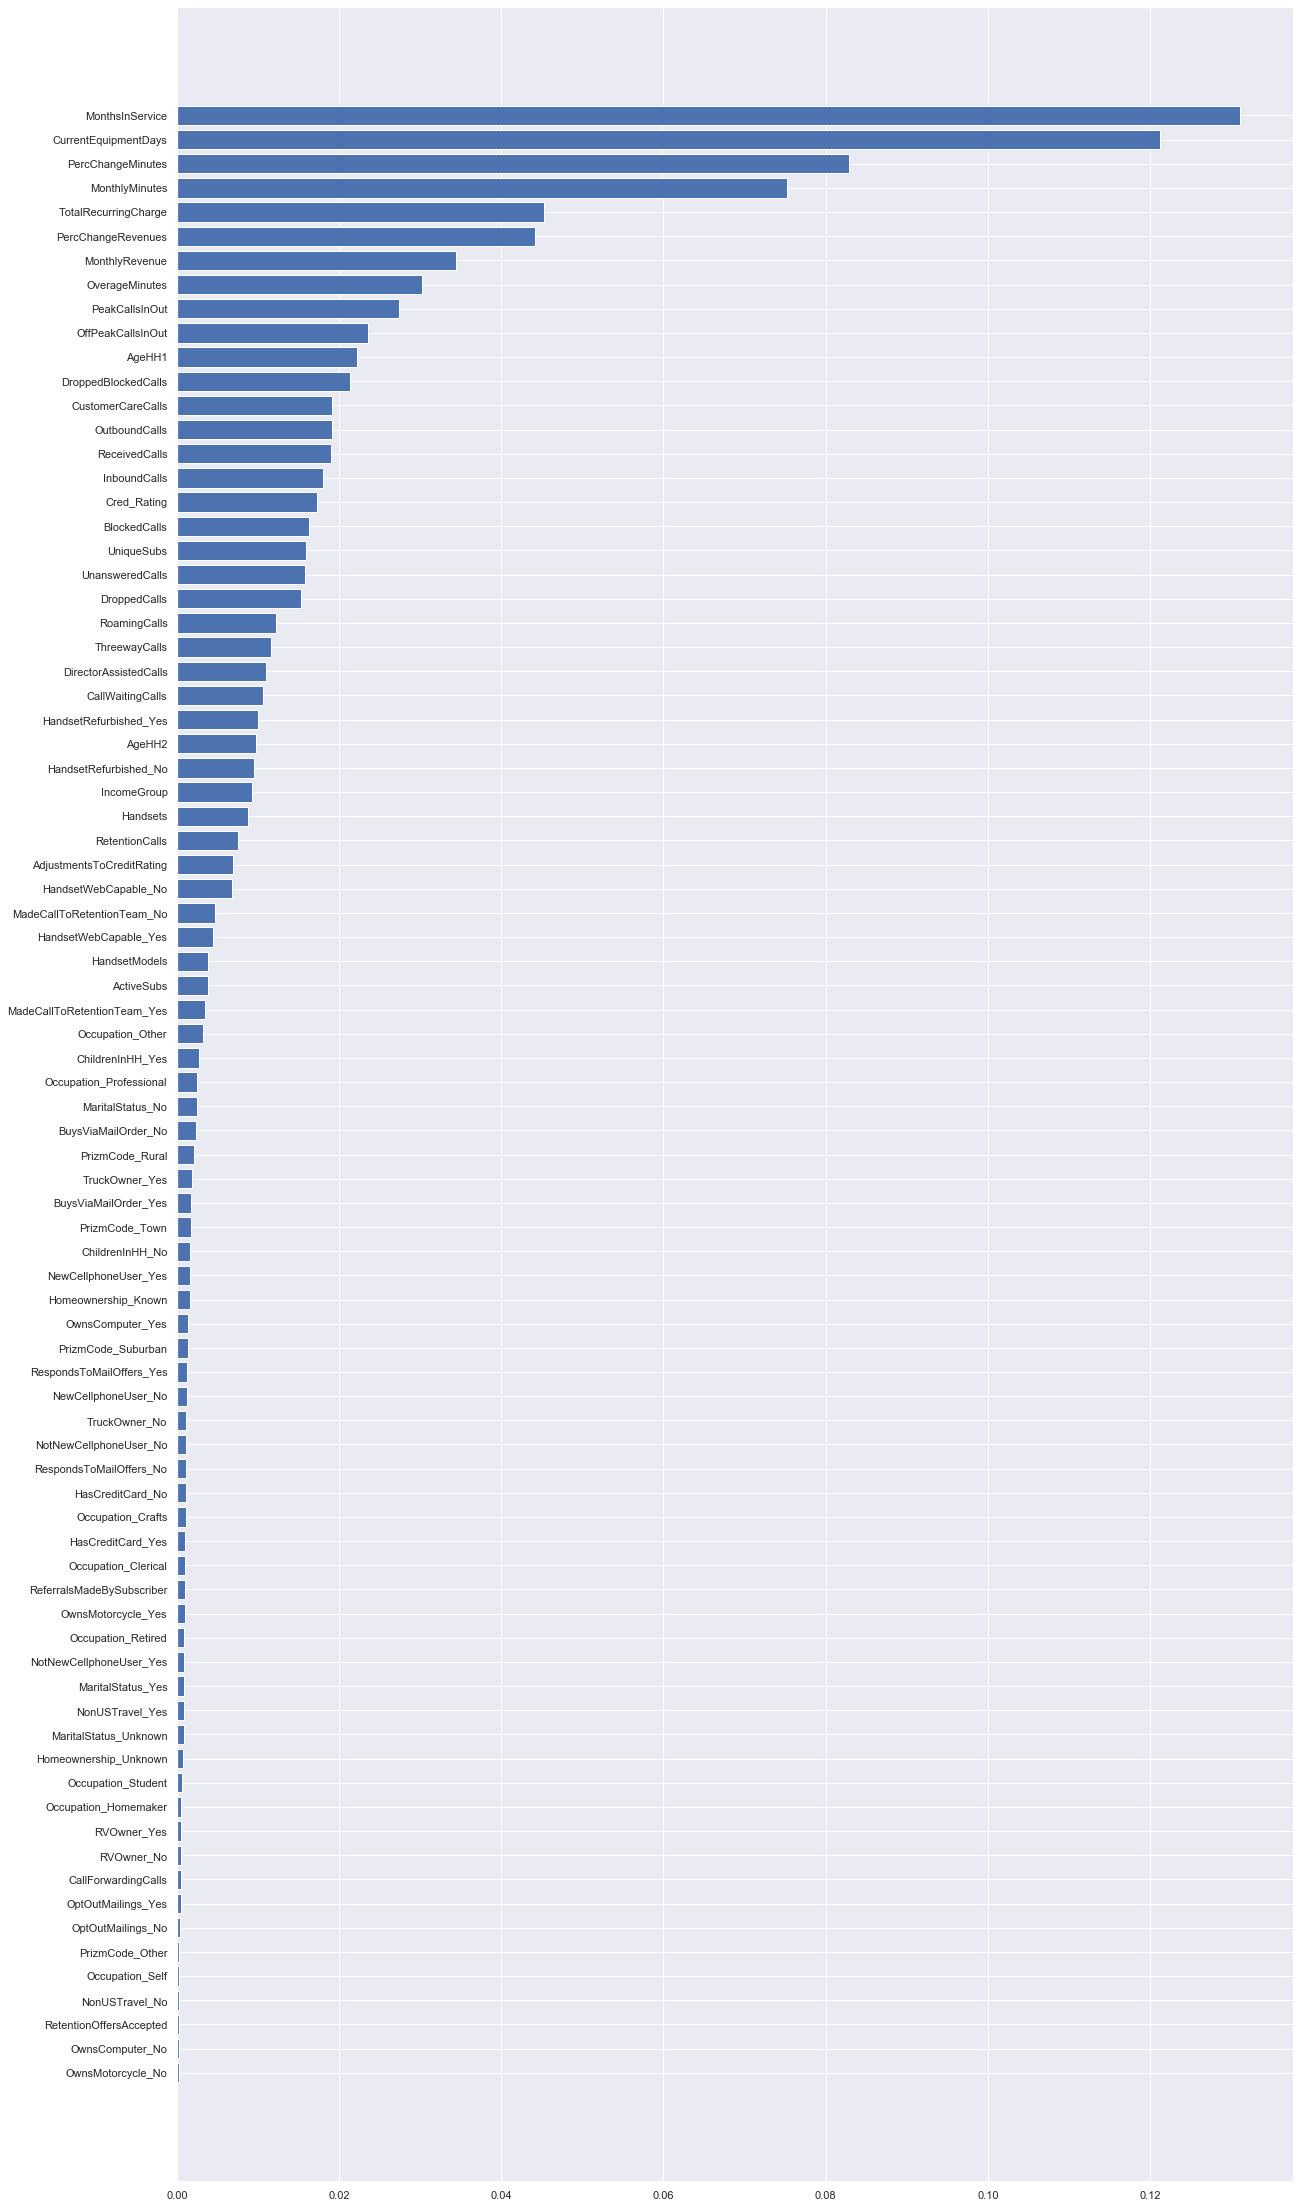

In [529]:
#Get array of feature importance of gradboost_under2 model
feat_imp = gradboost_under2.feature_importances_

#Get sorted index of feat_imp
sorted_index = np.argsort(feat_imp)

#Bar plot of feature importance
x_range = range(len(feat_imp))
labels = np.array(X_train_under.keys())[sorted_index]
plt.figure(figsize=(20, 40))
plt.barh(x_range, feat_imp[sorted_index], align='center')
plt.yticks(x_range, X_train_under.keys()[sorted_index])
plt.show()

Using the above feature importance list, I'll test the same model performance with the top features and compare to the original gradboost_under2 model that used all features.

In [496]:
#Creating array of sorted features variables based on feature importance from highest to lowest
X_train_under_feat_imp = X_train_under.keys()[sorted_index][::-1]

#New dataframes to store training and test datasets with selected features based on feature importance
X_train_under_imp = pd.DataFrame()
X_test_imp = pd.DataFrame()

#recall best parameters for gradboost_under2 model
gradboost_under.best_params_


{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 25,
 'n_estimators': 170,
 'random_state': 50,
 'subsample': 0.8}

In [497]:
#selecting top 15 features based on importance and comparing new model ROC_AUC score against original gradboost_under2 model
for n in range(15):
  #new model using best params, adjusting max_features to match number of features in new training and test datasets
  gradboost_imp = ensemble.GradientBoostingClassifier(learning_rate=0.1, loss='deviance', max_depth=4, max_features=n+1, n_estimators=170, random_state=50, subsample=0.8)

  #add next highest feature importance to training and testing dataset
  X_train_under_imp = pd.concat([X_train_under_imp, X_train_under[X_train_under_feat_imp[n]]], axis=1)
  X_test_imp = pd.concat([X_test_imp, X_test[X_train_under_feat_imp[n]]], axis=1)

  print('Top {} feature importance(s): {}\n'.format(n+1, X_train_under_imp.columns.values))

  #train model against newly selected features
  gradboost_imp.fit(X_train_under_imp, y_train_under)

  preds = gradboost_imp.predict(X_test_imp)
  print(classification_report(y_test, preds, target_names=['No Churn', 'Churn']))

  probs = gradboost_imp.predict_proba(X_test_imp)
  probs = probs[:, 1]

  fpr, tpr, _ = roc_curve(y_test, probs)
  print('\nROC AUC:', roc_auc_score(y_test, probs))
  print('---------------------------------------------------\n')

Top 1 feature importance(s): ['MonthsInService']

              precision    recall  f1-score   support

    No Churn       0.77      0.50      0.61      8918
       Churn       0.33      0.61      0.43      3526

    accuracy                           0.53     12444
   macro avg       0.55      0.56      0.52     12444
weighted avg       0.64      0.53      0.56     12444


ROC AUC: 0.5870490376998879
---------------------------------------------------

Top 2 feature importance(s): ['MonthsInService' 'CurrentEquipmentDays']

              precision    recall  f1-score   support

    No Churn       0.79      0.48      0.60      8918
       Churn       0.34      0.68      0.46      3526

    accuracy                           0.54     12444
   macro avg       0.57      0.58      0.53     12444
weighted avg       0.67      0.54      0.56     12444


ROC AUC: 0.6121259914336419
---------------------------------------------------

Top 3 feature importance(s): ['MonthsInService' 'CurrentEqu

#Final Notes
Using the feature importance of our gradient boost model, selecting the five most importance features still gives us a ROC_AUC score for Churn customers at 0.6470 compared to the original model that use all of the features at 0.6767.  Using only five features only loses us a ROC_AUC score of about 0.03 which in my opinion is acceptable. This allows our model to run much faster due to being less computationally excessive. Also, this allows us to use these features for other purposes such as customer retention programs.

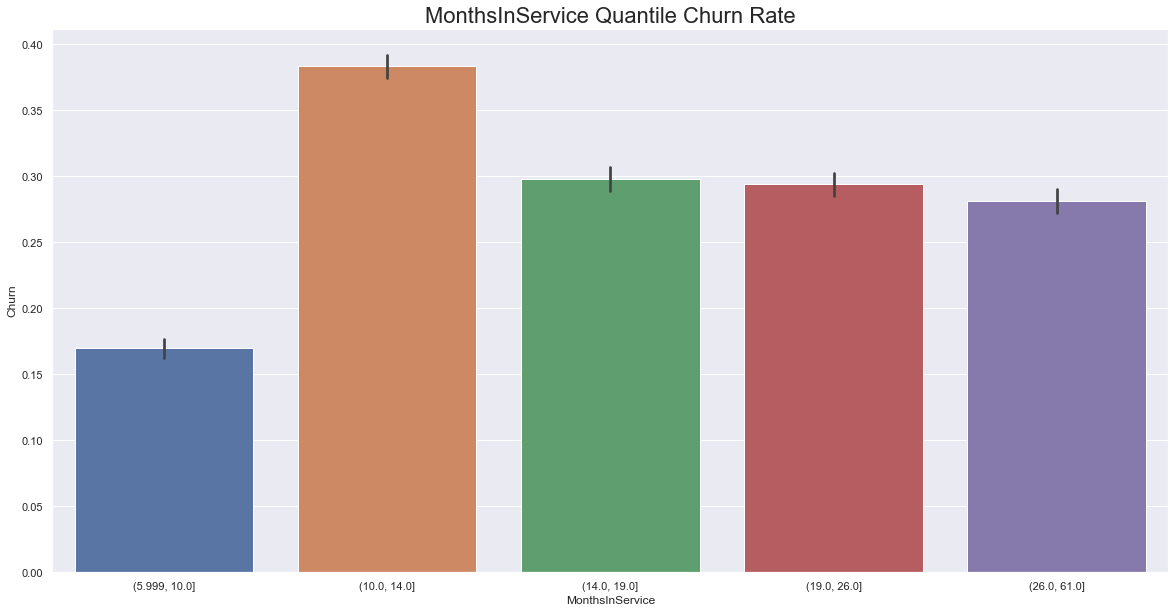

In [515]:
plt.figure(figsize=(20,10))
sns.barplot(pd.qcut(data_df['MonthsInService'], 5), data_df['Churn'])
plt.title('MonthsInService Quantile Churn Rate', fontdict={'fontsize': 22})
plt.show()

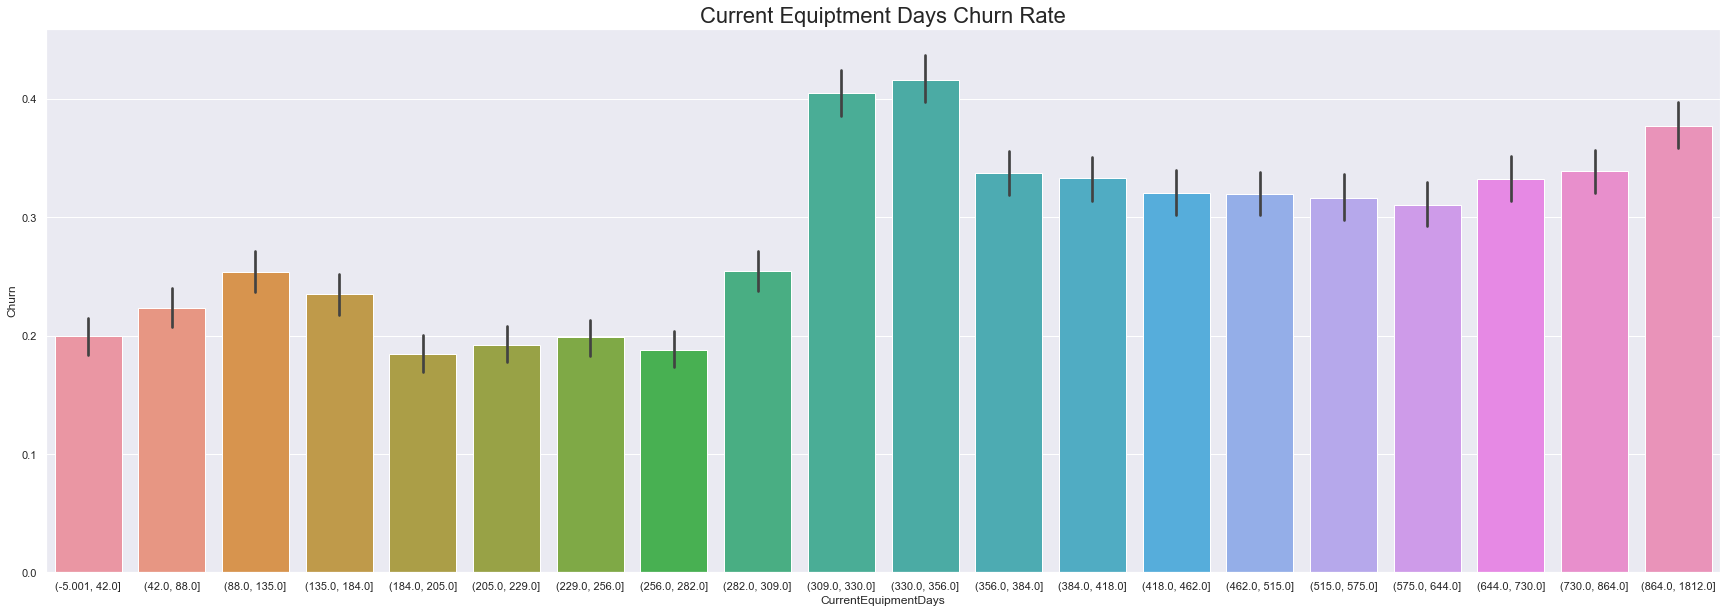

In [533]:
plt.figure(figsize=(30,10))
sns.barplot(pd.qcut(data_df['CurrentEquipmentDays'], 20), data_df['Churn'])
plt.title('Current Equiptment Days Churn Rate', fontdict={'fontsize': 22})
plt.show()

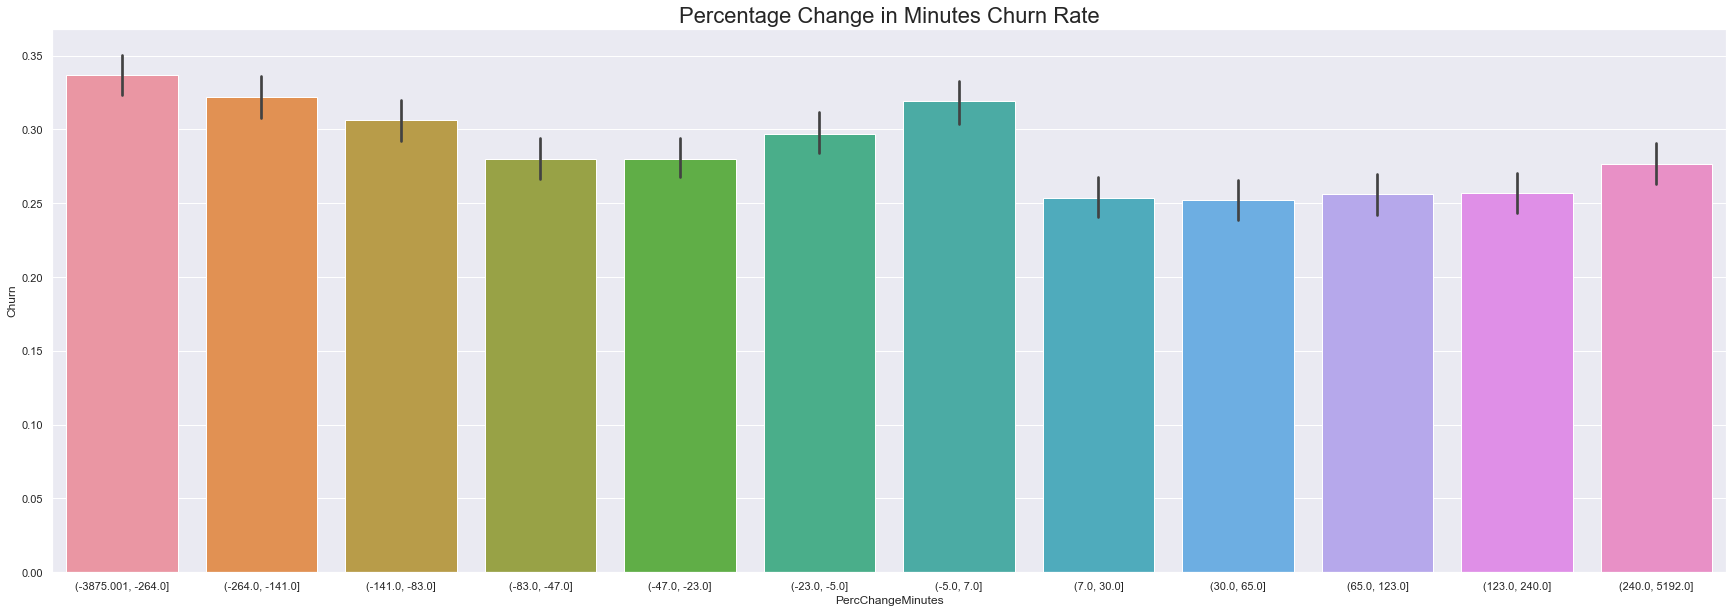

In [539]:
plt.figure(figsize=(30,10))
sns.barplot(pd.qcut(data_df['PercChangeMinutes'], 12), data_df['Churn'])
plt.title('Percentage Change in Minutes Churn Rate', fontdict={'fontsize': 22})
plt.show()

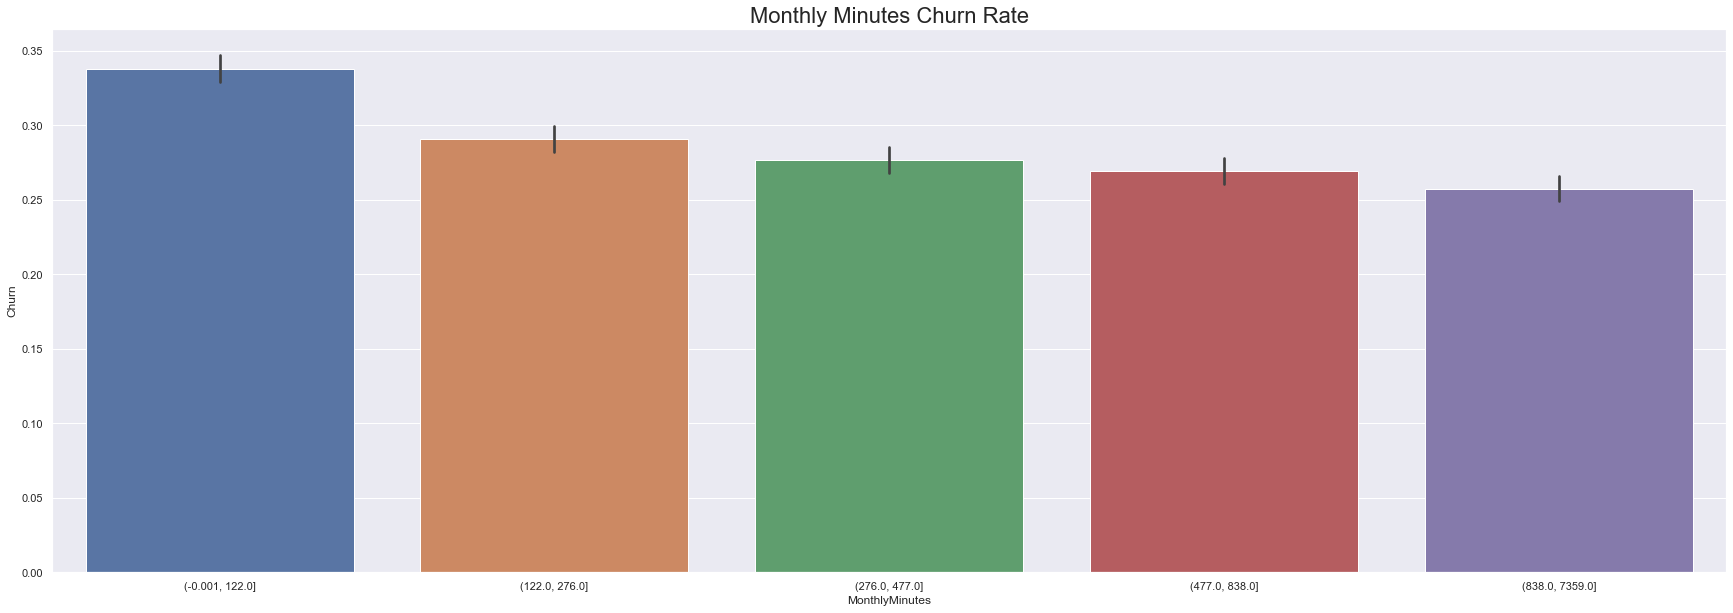

In [541]:
plt.figure(figsize=(30,10))
sns.barplot(pd.qcut(data_df['MonthlyMinutes'], 5), data_df['Churn'])
plt.title('Monthly Minutes Churn Rate', fontdict={'fontsize': 22})
plt.show()

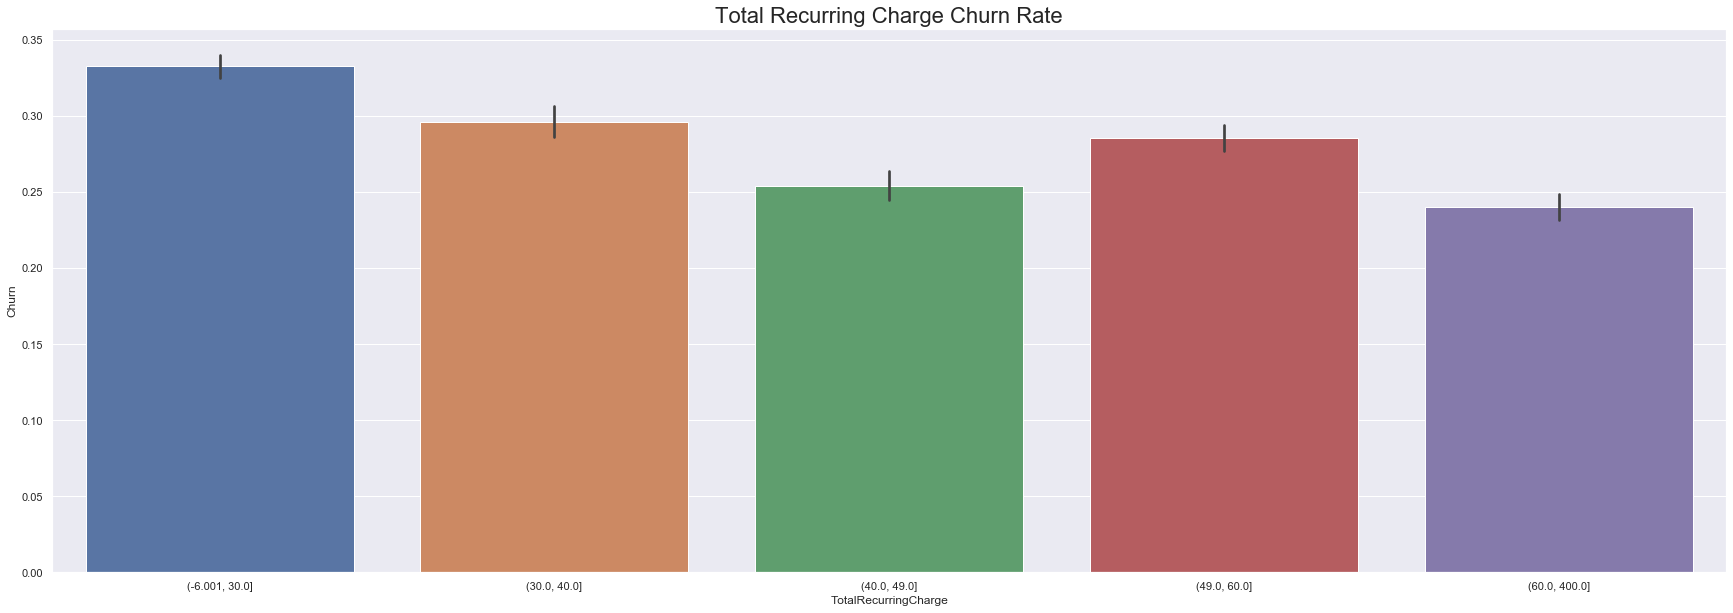

In [548]:
plt.figure(figsize=(30,10))
sns.barplot(pd.qcut(data_df['TotalRecurringCharge'], 5, duplicates='drop'), data_df['Churn'])
plt.title('Total Recurring Charge Churn Rate', fontdict={'fontsize': 22})
plt.show()